In [1]:
import wave
import json
import librosa
import csv
import numpy as np
from pywt import wavedec
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2024-01-15 22:39:12.933581: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 22:39:12.970729: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-15 22:39:12.970767: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-15 22:39:12.970791: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-15 22:39:12.977088: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-15 22:39:12.977796: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
import wave
import json

def reset_csv():
  header = 'filename'
  for i in range(1, 41):
      header += f' mfcc{i}'
  for i in range(1, 13):
    header += f' chroma{i}'
  for i in range(1, 61):
    header += f' cqt{i}'
  header += ' label'
  header = header.split()
  file = open('testing.csv', 'w', newline='')
  with file:
      writer = csv.writer(file)
      writer.writerow(header)

In [4]:
def getModelArray(model_name):
  model_path = '../modelh5/'+model_name+'/best_model/'
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(model_path)):
    filenames.sort()
    filenames = filenames[10:] + filenames[:10]
    # cut each 10 array
    filenames = [filenames[i:i + 10] for i in range(0, len(filenames), 10)]
    return filenames[0], filenames[1], filenames[2], filenames[3], filenames[4], filenames[5], filenames[6], filenames[7], filenames[8], filenames[9]

def getPathModel(model_name):
  a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = getModelArray(model_name)
  # switch index 2 to 10
  hasil = []
  for i in [a1, a2, a3, a4, a5, a6, a7, a8, a9, a10]:
    a = i[1]
    i.pop(1)
    i.append(a)
    for j in range(len(i)):
      i[j] = '../modelh5/'+model_name + '/best_model/' + i[j]
  return a1, a2, a3, a4, a5, a6, a7, a8, a9, a10

In [5]:
def testingVHD(array, db):
    index_db = 0
    accuracy_all = []
    precision_all = []
    sensitivity_all = []
    specificity_all = []
    f1_score_all = []

    for model_path in array:
        print("=======================================================")
        print("Processing "+ model_path)
        print("=======================================================")
        dataset_path = '../../data/testing_10/'
        reset_csv()

        for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
                # ensure we're processing a genre sub-folder level
                if dirpath is not dataset_path:
                    semantic_label = dirpath.split("/")[-1]
                    for f in filenames:
                        file_path = os.path.join(dirpath, f)
                        to_append = f'{file_path}'
                        # print(file_path)
                        y, sr = librosa.load(file_path, mono=True, duration=3, sr=8000)
                        coeffs = wavedec(y, f'db{db}', level=10)
                        cA,cD10,cD9,cD8,cD7,cD6,cD5,cD4,cD3,cD2, cD1 = coeffs
                        list_cd = [cD1, cD2, cD3, cD4, cD5, cD6, cD7, cD8, cD9, cD10]
                        mfcc = librosa.feature.mfcc(y=list_cd[index_db], sr=8000, n_mfcc=40, n_fft=2048, hop_length=512, n_mels=128)
                        rms = librosa.feature.chroma_stft(y=list_cd[index_db], sr=8000)
                        cqt = np.abs(librosa.cqt(y=list_cd[index_db], sr=sr, n_bins=60))
                        combined_features = np.concatenate((mfcc, rms, cqt), axis=0)
                        to_append = f'{file_path}'
                        for e in combined_features:
                            to_append += f' {np.mean(e.T, axis=0)}'
                        to_append += f' {semantic_label}'
                        file = open('testing.csv', 'a', newline='')
                        with file:
                            writer = csv.writer(file)
                            writer.writerow(to_append.split())
        index_db += 1
        data = pd.read_csv('./testing.csv')
        
        lb = LabelEncoder()
        X = np.expand_dims(data.drop(['label', 'filename'], axis=1), axis=2)
        y = np.expand_dims(data.iloc[:, -1], axis=1)


        model = tf.keras.models.load_model(model_path)
        pred = model.predict(X)
        hasil = []
        class_labels = ['AS', 'MR', 'MS', 'MVP', 'N']
        # class_labels = ['MVP', 'MS', 'N', 'MR', 'AS']
        for predic in pred:
            cek = np.argmax(predic)
            hasil.append(class_labels[cek])
        # y_p = np.argmax(pred, axis=1)

        cm = confusion_matrix(y, hasil)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['AS', 'MR', 'MS', 'MVP', 'N'])
        disp.plot()
        plt.show()

        FP = cm.sum(axis=0) - np.diag(cm)  
        FN = cm.sum(axis=1) - np.diag(cm)
        TP = np.diag(cm)
        TN = cm.sum() - (FP + FN + TP)

        # Sensitivity, hit rate, recall, or true positive rate
        TPR = TP/(TP+FN)
        # Specificity or true negative rate
        TNR = TN/(TN+FP) 
        # Precision or positive predictive value
        PPV = TP/(TP+FP)
        # Negative predictive value
        NPV = TN/(TN+FN)
        # Fall out or false positive rate
        FPR = FP/(FP+TN)
        # False negative rate
        FNR = FN/(TP+FN)
        # False discovery rate
        FDR = FP/(TP+FP)

        # Overall accuracy
        ACC = (TP+TN)/(TP+FP+FN+TN)

        print("Accuracy :" , ACC, 'mean: ', np.mean(ACC))
        print("Precision :" , PPV, 'mean: ', np.mean(PPV))
        print("Sensitivity :" , TPR, 'mean: ', np.mean(TPR))
        print("Specificity :" , TNR, 'mean: ', np.mean(TNR))
        print("f1_score:", 2 * (PPV * TPR) / (PPV + TPR), 'mean: ', np.mean(2 * (PPV * TPR) / (PPV + TPR)))

        accuracy_all.append(np.mean(ACC))
        precision_all.append(np.mean(PPV))
        sensitivity_all.append(np.mean(TPR))
        specificity_all.append(np.mean(TNR))
        f1_score_all.append(np.mean(2 * (PPV * TPR) / (PPV + TPR)))

        print("\n\n")

    print("=======================================================")
    print("Accuracy All :" , accuracy_all)
    print("Precision All :" , precision_all)
    print("Sensitivity All :" , sensitivity_all)
    print("Specificity All :" , specificity_all)
    print("f1_score All :", f1_score_all)
    print("=======================================================")




In [6]:
a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = getPathModel("LSTM_FT")

Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb1L1.csv_4.h5


4/4 [==============================] - 1s 8ms/step


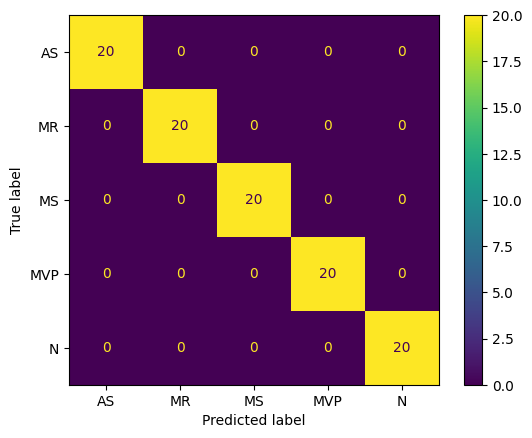

Accuracy : [1. 1. 1. 1. 1.] mean:  1.0
Precision : [1. 1. 1. 1. 1.] mean:  1.0
Sensitivity : [1. 1. 1. 1. 1.] mean:  1.0
Specificity : [1. 1. 1. 1. 1.] mean:  1.0
f1_score: [1. 1. 1. 1. 1.] mean:  1.0



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb1L2.csv_2.h5
4/4 [==============================] - 0s 8ms/step


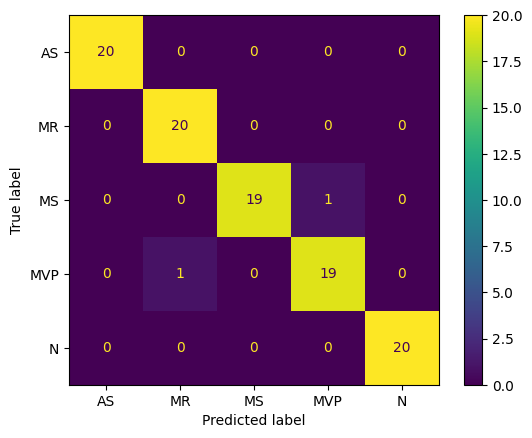

Accuracy : [1.   0.99 0.99 0.98 1.  ] mean:  0.992
Precision : [1.         0.95238095 1.         0.95       1.        ] mean:  0.9804761904761905
Sensitivity : [1.   1.   0.95 0.95 1.  ] mean:  0.9800000000000001
Specificity : [1.     0.9875 1.     0.9875 1.    ] mean:  0.9949999999999999
f1_score: [1.         0.97560976 0.97435897 0.95       1.        ] mean:  0.9799937460913071



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb1L3.csv_2.h5
4/4 [==============================] - 0s 8ms/step


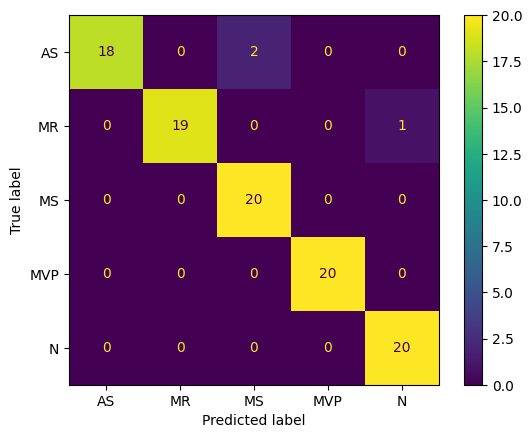

Accuracy : [0.98 0.99 0.98 1.   0.99] mean:  0.9880000000000001
Precision : [1.         1.         0.90909091 1.         0.95238095] mean:  0.9722943722943723
Sensitivity : [0.9  0.95 1.   1.   1.  ] mean:  0.97
Specificity : [1.     1.     0.975  1.     0.9875] mean:  0.9925
f1_score: [0.94736842 0.97435897 0.95238095 1.         0.97560976] mean:  0.9699436207780238



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb1L4.csv_3.h5
4/4 [==============================] - 0s 9ms/step


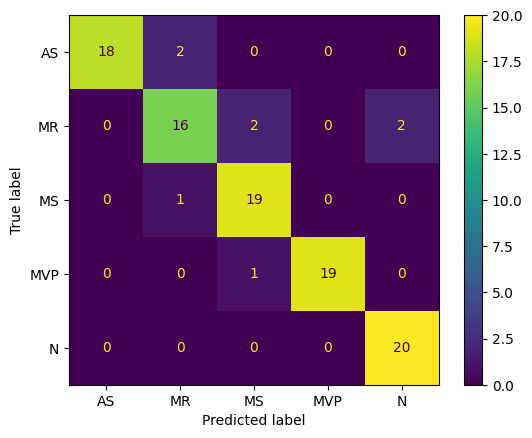

Accuracy : [0.98 0.93 0.96 0.99 0.98] mean:  0.968
Precision : [1.         0.84210526 0.86363636 1.         0.90909091] mean:  0.9229665071770334
Sensitivity : [0.9  0.8  0.95 0.95 1.  ] mean:  0.9200000000000002
Specificity : [1.     0.9625 0.9625 1.     0.975 ] mean:  0.9799999999999999
f1_score: [0.94736842 0.82051282 0.9047619  0.97435897 0.95238095] mean:  0.9198766146134567



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb1L5.csv_5.h5
4/4 [==============================] - 0s 11ms/step


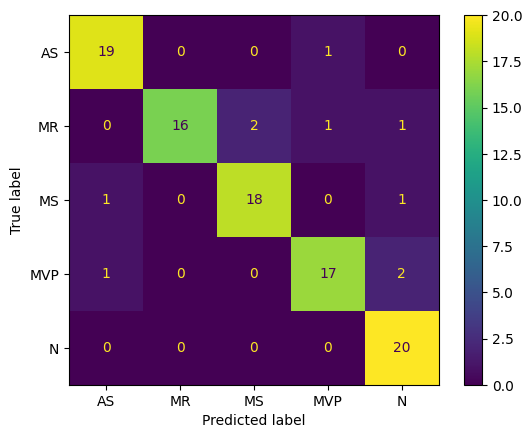

Accuracy : [0.97 0.96 0.96 0.95 0.96] mean:  0.96
Precision : [0.9047619  1.         0.9        0.89473684 0.83333333] mean:  0.9065664160401002
Sensitivity : [0.95 0.8  0.9  0.85 1.  ] mean:  0.9
Specificity : [0.975 1.    0.975 0.975 0.95 ] mean:  0.975
f1_score: [0.92682927 0.88888889 0.9        0.87179487 0.90909091] mean:  0.8993207876134705



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb1L6.csv_5.h5
4/4 [==============================] - 0s 10ms/step


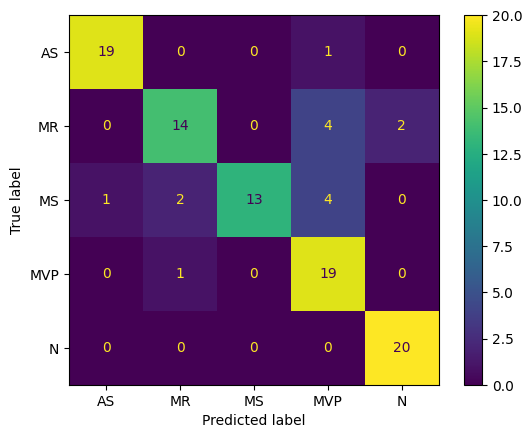

Accuracy : [0.98 0.91 0.93 0.9  0.98] mean:  0.9400000000000001
Precision : [0.95       0.82352941 1.         0.67857143 0.90909091] mean:  0.8722383498854087
Sensitivity : [0.95 0.7  0.65 0.95 1.  ] mean:  0.85
Specificity : [0.9875 0.9625 1.     0.8875 0.975 ] mean:  0.9625
f1_score: [0.95       0.75675676 0.78787879 0.79166667 0.95238095] mean:  0.8477366327366328



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb1L7.csv_5.h5
4/4 [==============================] - 0s 8ms/step


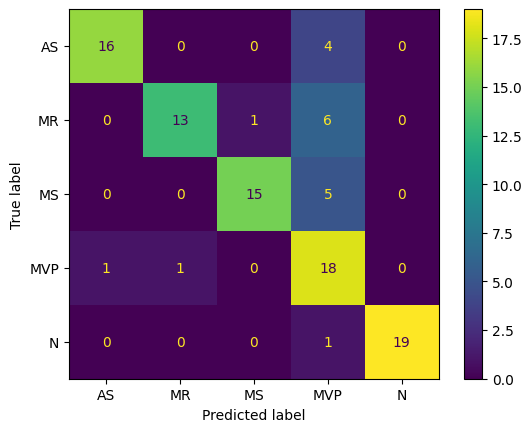

Accuracy : [0.95 0.92 0.94 0.82 0.99] mean:  0.924
Precision : [0.94117647 0.92857143 0.9375     0.52941176 1.        ] mean:  0.8673319327731093
Sensitivity : [0.8  0.65 0.75 0.9  0.95] mean:  0.8099999999999999
Specificity : [0.9875 0.9875 0.9875 0.8    1.    ] mean:  0.9525
f1_score: [0.86486486 0.76470588 0.83333333 0.66666667 0.97435897] mean:  0.8207859443153561



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb1L8.csv_2.h5
4/4 [==============================] - 0s 8ms/step


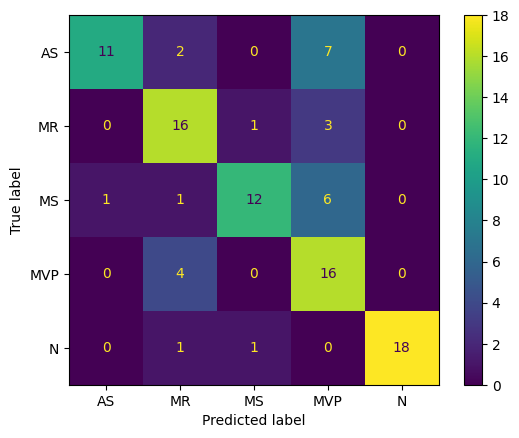

Accuracy : [0.9  0.88 0.9  0.8  0.98] mean:  0.8920000000000001
Precision : [0.91666667 0.66666667 0.85714286 0.5        1.        ] mean:  0.7880952380952381
Sensitivity : [0.55 0.8  0.6  0.8  0.9 ] mean:  0.73
Specificity : [0.9875 0.9    0.975  0.8    1.    ] mean:  0.9325000000000001
f1_score: [0.6875     0.72727273 0.70588235 0.61538462 0.94736842] mean:  0.73668162333023



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb1L9.csv_4.h5
4/4 [==============================] - 0s 7ms/step


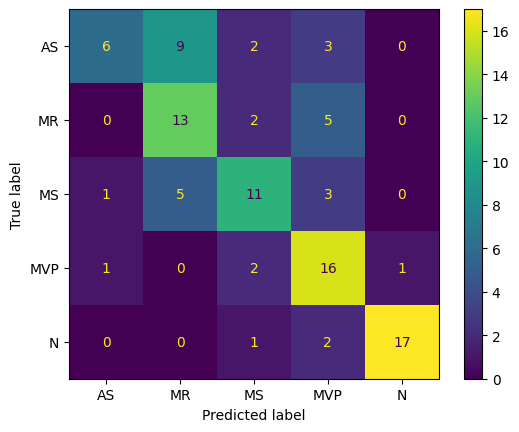

Accuracy : [0.84 0.79 0.84 0.83 0.96] mean:  0.852
Precision : [0.75       0.48148148 0.61111111 0.55172414 0.94444444] mean:  0.6677522349936144
Sensitivity : [0.3  0.65 0.55 0.8  0.85] mean:  0.63
Specificity : [0.975  0.825  0.9125 0.8375 0.9875] mean:  0.9075
f1_score: [0.42857143 0.55319149 0.57894737 0.65306122 0.89473684] mean:  0.6217016705898485



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb1L10.csv_5.h5
4/4 [==============================] - 0s 7ms/step


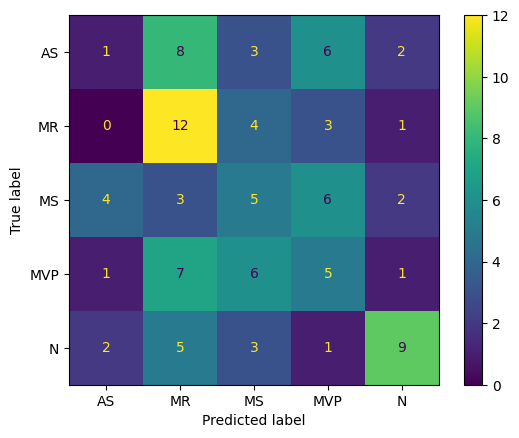

Accuracy : [0.74 0.69 0.69 0.69 0.83] mean:  0.728
Precision : [0.125      0.34285714 0.23809524 0.23809524 0.6       ] mean:  0.30880952380952376
Sensitivity : [0.05 0.6  0.25 0.25 0.45] mean:  0.31999999999999995
Specificity : [0.9125 0.7125 0.8    0.8    0.925 ] mean:  0.8299999999999998
f1_score: [0.07142857 0.43636364 0.24390244 0.24390244 0.51428571] mean:  0.3019765600253405



Accuracy All : [1.0, 0.992, 0.9880000000000001, 0.968, 0.96, 0.9400000000000001, 0.924, 0.8920000000000001, 0.852, 0.728]
Precision All : [1.0, 0.9804761904761905, 0.9722943722943723, 0.9229665071770334, 0.9065664160401002, 0.8722383498854087, 0.8673319327731093, 0.7880952380952381, 0.6677522349936144, 0.30880952380952376]
Sensitivity All : [1.0, 0.9800000000000001, 0.97, 0.9200000000000002, 0.9, 0.85, 0.8099999999999999, 0.73, 0.63, 0.31999999999999995]
Specificity All : [1.0, 0.9949999999999999, 0.9925, 0.9799999999999999, 0.975, 0.9625, 0.9525, 0.9325000000000001, 0.9075, 0.8299999999999998]
f1_score A

In [7]:
testingVHD(a1, 1)

Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb2L1.csv_4.h5
4/4 [==============================] - 0s 8ms/step


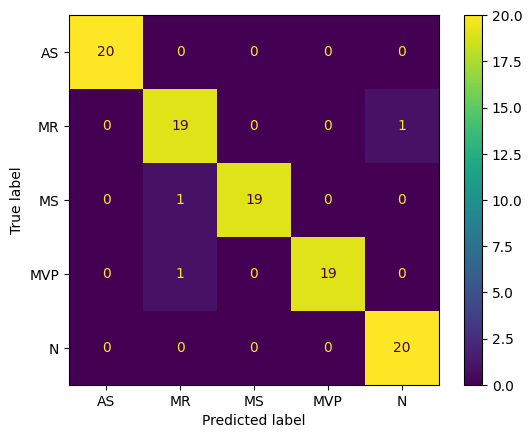

Accuracy : [1.   0.97 0.99 0.99 0.99] mean:  0.9880000000000001
Precision : [1.         0.9047619  1.         1.         0.95238095] mean:  0.9714285714285713
Sensitivity : [1.   0.95 0.95 0.95 1.  ] mean:  0.97
Specificity : [1.     0.975  1.     1.     0.9875] mean:  0.9925
f1_score: [1.         0.92682927 0.97435897 0.97435897 0.97560976] mean:  0.9702313946216385



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb2L2.csv_2.h5
4/4 [==============================] - 0s 8ms/step


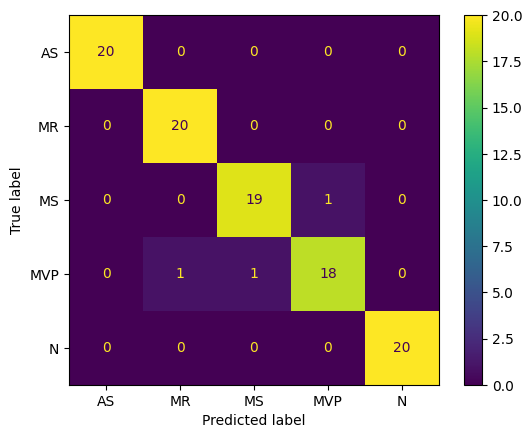

Accuracy : [1.   0.99 0.98 0.97 1.  ] mean:  0.9879999999999999
Precision : [1.         0.95238095 0.95       0.94736842 1.        ] mean:  0.9699498746867168
Sensitivity : [1.   1.   0.95 0.9  1.  ] mean:  0.97
Specificity : [1.     0.9875 0.9875 0.9875 1.    ] mean:  0.9925
f1_score: [1.         0.97560976 0.95       0.92307692 1.        ] mean:  0.9697373358348969



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb2L3.csv_2.h5
4/4 [==============================] - 0s 8ms/step


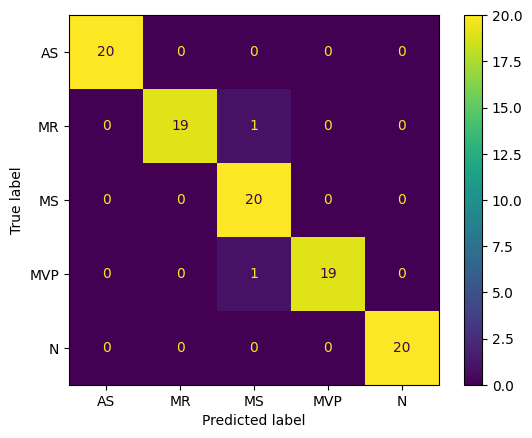

Accuracy : [1.   0.99 0.98 0.99 1.  ] mean:  0.992
Precision : [1.         1.         0.90909091 1.         1.        ] mean:  0.9818181818181818
Sensitivity : [1.   0.95 1.   0.95 1.  ] mean:  0.9800000000000001
Specificity : [1.    1.    0.975 1.    1.   ] mean:  0.9949999999999999
f1_score: [1.         0.97435897 0.95238095 0.97435897 1.        ] mean:  0.9802197802197803



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb2L4.csv_5.h5
4/4 [==============================] - 0s 8ms/step


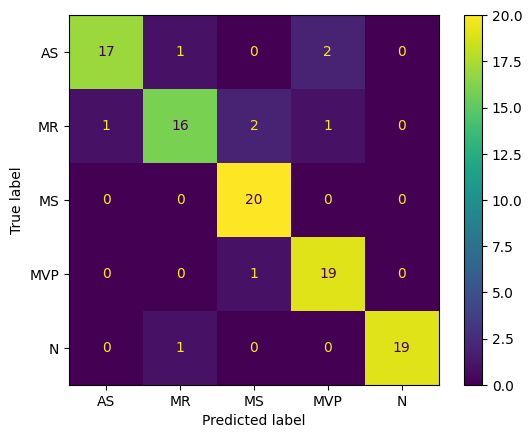

Accuracy : [0.96 0.94 0.97 0.96 0.99] mean:  0.9640000000000001
Precision : [0.94444444 0.88888889 0.86956522 0.86363636 1.        ] mean:  0.9133069828722004
Sensitivity : [0.85 0.8  1.   0.95 0.95] mean:  0.9099999999999999
Specificity : [0.9875 0.975  0.9625 0.9625 1.    ] mean:  0.9774999999999998
f1_score: [0.89473684 0.84210526 0.93023256 0.9047619  0.97435897] mean:  0.9092391085047143



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb2L5.csv_5.h5
4/4 [==============================] - 0s 7ms/step


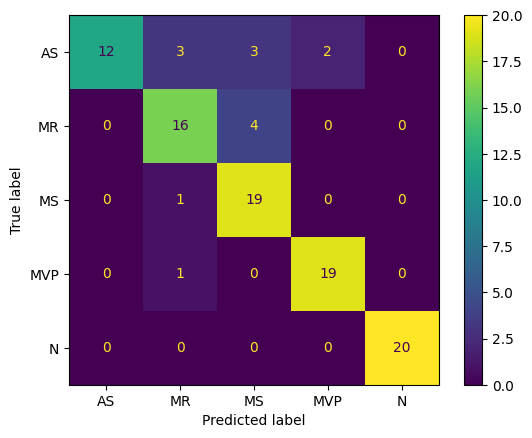

Accuracy : [0.92 0.91 0.92 0.97 1.  ] mean:  0.944
Precision : [1.         0.76190476 0.73076923 0.9047619  1.        ] mean:  0.8794871794871796
Sensitivity : [0.6  0.8  0.95 0.95 1.  ] mean:  0.86
Specificity : [1.     0.9375 0.9125 0.975  1.    ] mean:  0.9650000000000001
f1_score: [0.75       0.7804878  0.82608696 0.92682927 1.        ] mean:  0.8566808059384942



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb2L6.csv_2.h5
4/4 [==============================] - 0s 8ms/step


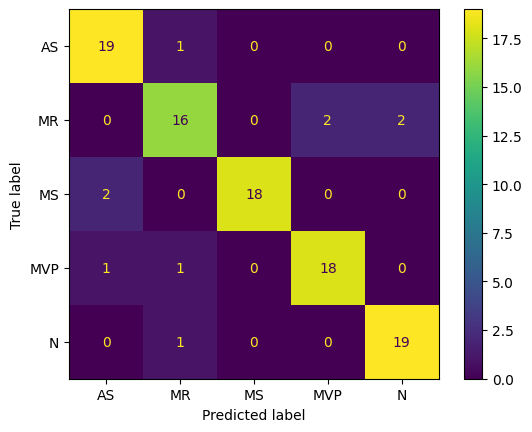

Accuracy : [0.96 0.93 0.98 0.96 0.97] mean:  0.96
Precision : [0.86363636 0.84210526 1.         0.9        0.9047619 ] mean:  0.9021007063112327
Sensitivity : [0.95 0.8  0.9  0.9  0.95] mean:  0.9
Specificity : [0.9625 0.9625 1.     0.975  0.975 ] mean:  0.975
f1_score: [0.9047619  0.82051282 0.94736842 0.9        0.92682927] mean:  0.8998944829240081



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb2L7.csv_3.h5
4/4 [==============================] - 0s 8ms/step


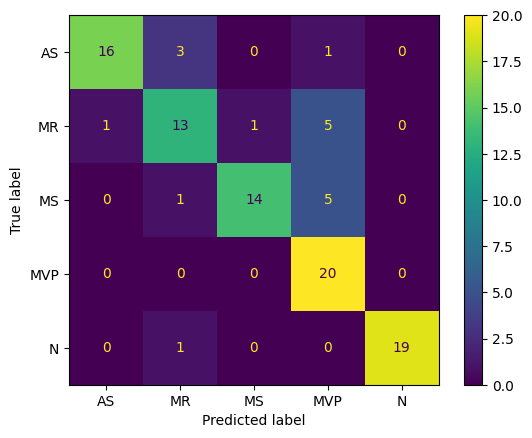

Accuracy : [0.95 0.88 0.93 0.89 0.99] mean:  0.9280000000000002
Precision : [0.94117647 0.72222222 0.93333333 0.64516129 1.        ] mean:  0.8483786632932742
Sensitivity : [0.8  0.65 0.7  1.   0.95] mean:  0.8200000000000001
Specificity : [0.9875 0.9375 0.9875 0.8625 1.    ] mean:  0.9550000000000001
f1_score: [0.86486486 0.68421053 0.8        0.78431373 0.97435897] mean:  0.821549618205965



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb2L8.csv_5.h5
4/4 [==============================] - 0s 8ms/step


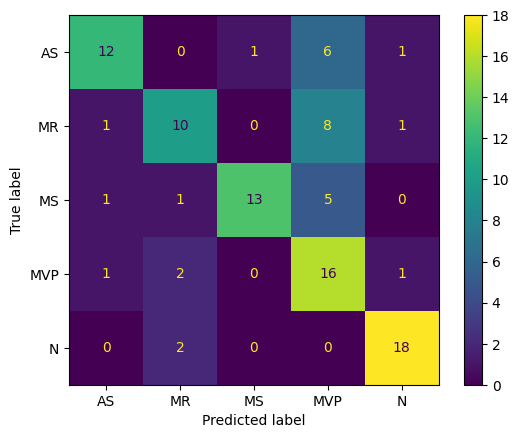

Accuracy : [0.89 0.85 0.92 0.77 0.95] mean:  0.876
Precision : [0.8        0.66666667 0.92857143 0.45714286 0.85714286] mean:  0.7419047619047621
Sensitivity : [0.6  0.5  0.65 0.8  0.9 ] mean:  0.69
Specificity : [0.9625 0.9375 0.9875 0.7625 0.9625] mean:  0.9225000000000001
f1_score: [0.68571429 0.57142857 0.76470588 0.58181818 0.87804878] mean:  0.696343140360357



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb2L9.csv_5.h5
4/4 [==============================] - 0s 8ms/step


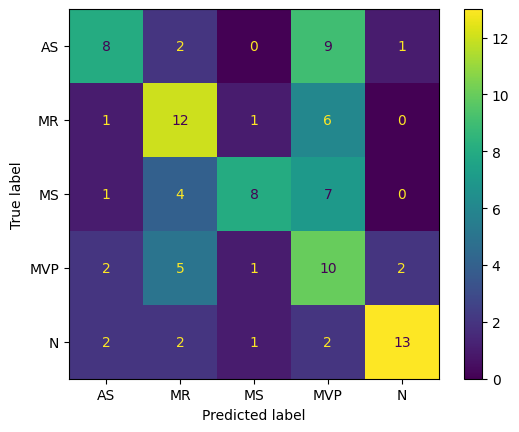

Accuracy : [0.82 0.79 0.85 0.66 0.9 ] mean:  0.804
Precision : [0.57142857 0.48       0.72727273 0.29411765 0.8125    ] mean:  0.5770637891520244
Sensitivity : [0.4  0.6  0.4  0.5  0.65] mean:  0.51
Specificity : [0.925  0.8375 0.9625 0.7    0.9625] mean:  0.8775000000000001
f1_score: [0.47058824 0.53333333 0.51612903 0.37037037 0.72222222] mean:  0.5225286386956216



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb2L10.csv_1.h5
4/4 [==============================] - 0s 8ms/step


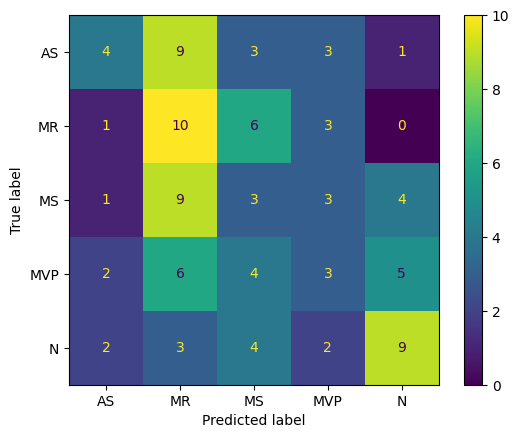

Accuracy : [0.78 0.63 0.66 0.72 0.79] mean:  0.716
Precision : [0.4        0.27027027 0.15       0.21428571 0.47368421] mean:  0.3016480390164601
Sensitivity : [0.2  0.5  0.15 0.15 0.45] mean:  0.29
Specificity : [0.925  0.6625 0.7875 0.8625 0.875 ] mean:  0.8225
f1_score: [0.26666667 0.35087719 0.15       0.17647059 0.46153846] mean:  0.2811105818845757



Accuracy All : [0.9880000000000001, 0.9879999999999999, 0.992, 0.9640000000000001, 0.944, 0.96, 0.9280000000000002, 0.876, 0.804, 0.716]
Precision All : [0.9714285714285713, 0.9699498746867168, 0.9818181818181818, 0.9133069828722004, 0.8794871794871796, 0.9021007063112327, 0.8483786632932742, 0.7419047619047621, 0.5770637891520244, 0.3016480390164601]
Sensitivity All : [0.97, 0.97, 0.9800000000000001, 0.9099999999999999, 0.86, 0.9, 0.8200000000000001, 0.69, 0.51, 0.29]
Specificity All : [0.9925, 0.9925, 0.9949999999999999, 0.9774999999999998, 0.9650000000000001, 0.975, 0.9550000000000001, 0.9225000000000001, 0.8775000000000001, 0.82

In [8]:
testingVHD(a2, 2)

Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb3L1.csv_2.h5


4/4 [==============================] - 0s 10ms/step


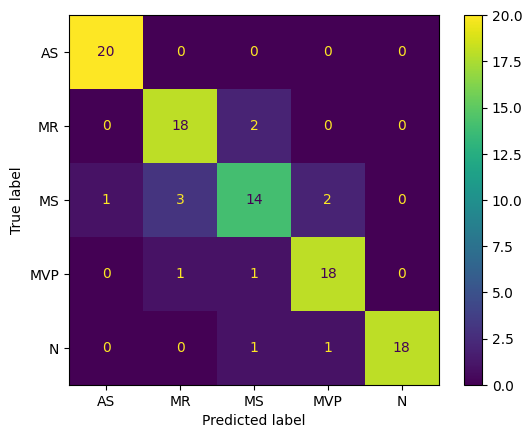

Accuracy : [0.99 0.94 0.9  0.95 0.98] mean:  0.952
Precision : [0.95238095 0.81818182 0.77777778 0.85714286 1.        ] mean:  0.881096681096681
Sensitivity : [1.  0.9 0.7 0.9 0.9] mean:  0.8799999999999999
Specificity : [0.9875 0.95   0.95   0.9625 1.    ] mean:  0.97
f1_score: [0.97560976 0.85714286 0.73684211 0.87804878 0.94736842] mean:  0.8790023840088026



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb3L2.csv_2.h5
4/4 [==============================] - 0s 8ms/step


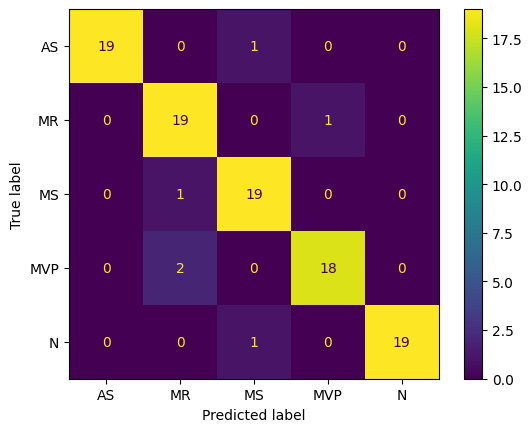

Accuracy : [0.99 0.96 0.97 0.97 0.99] mean:  0.976
Precision : [1.         0.86363636 0.9047619  0.94736842 1.        ] mean:  0.9431533378901801
Sensitivity : [0.95 0.95 0.95 0.9  0.95] mean:  0.9399999999999998
Specificity : [1.     0.9625 0.975  0.9875 1.    ] mean:  0.985
f1_score: [0.97435897 0.9047619  0.92682927 0.92307692 0.97435897] mean:  0.9406772089698918



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb3L3.csv_2.h5
4/4 [==============================] - 0s 8ms/step


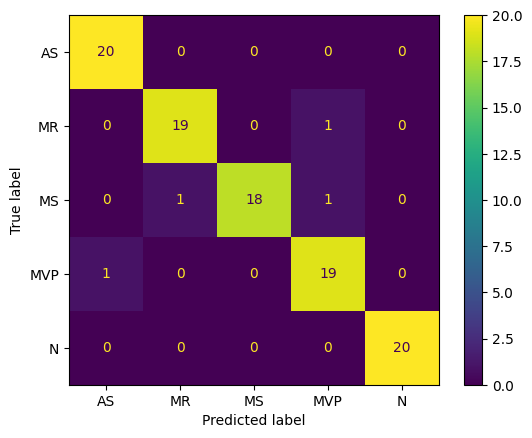

Accuracy : [0.99 0.98 0.98 0.97 1.  ] mean:  0.984
Precision : [0.95238095 0.95       1.         0.9047619  1.        ] mean:  0.9614285714285714
Sensitivity : [1.   0.95 0.9  0.95 1.  ] mean:  0.96
Specificity : [0.9875 0.9875 1.     0.975  1.    ] mean:  0.99
f1_score: [0.97560976 0.95       0.94736842 0.92682927 1.        ] mean:  0.9599614890885751



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb3L4.csv_2.h5
4/4 [==============================] - 0s 7ms/step


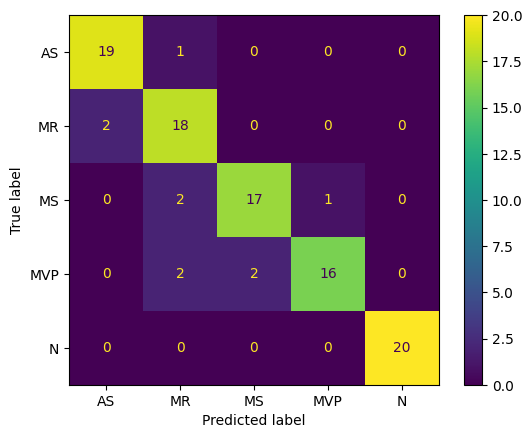

Accuracy : [0.97 0.93 0.95 0.95 1.  ] mean:  0.96
Precision : [0.9047619  0.7826087  0.89473684 0.94117647 1.        ] mean:  0.9046567826215155
Sensitivity : [0.95 0.9  0.85 0.8  1.  ] mean:  0.9
Specificity : [0.975  0.9375 0.975  0.9875 1.    ] mean:  0.975
f1_score: [0.92682927 0.8372093  0.87179487 0.86486486 1.        ] mean:  0.9001396614556002



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb3L5.csv_2.h5
4/4 [==============================] - 0s 8ms/step


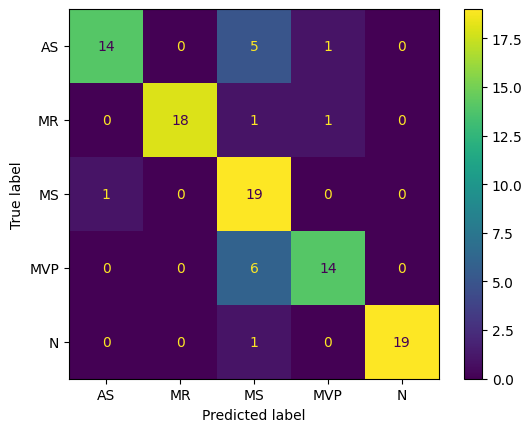

Accuracy : [0.93 0.98 0.86 0.92 0.99] mean:  0.9359999999999999
Precision : [0.93333333 1.         0.59375    0.875      1.        ] mean:  0.8804166666666667
Sensitivity : [0.7  0.9  0.95 0.7  0.95] mean:  0.8400000000000001
Specificity : [0.9875 1.     0.8375 0.975  1.    ] mean:  0.9600000000000002
f1_score: [0.8        0.94736842 0.73076923 0.77777778 0.97435897] mean:  0.846054880791723



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb3L6.csv_4.h5
4/4 [==============================] - 0s 8ms/step


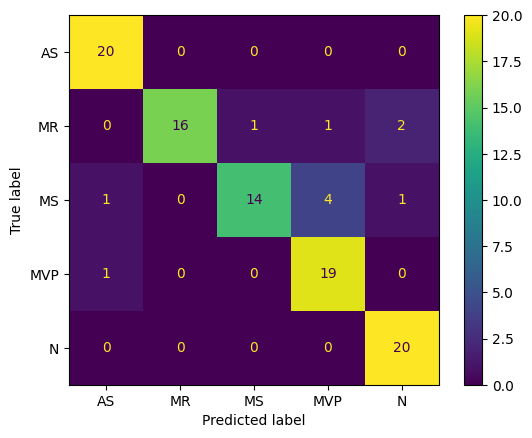

Accuracy : [0.98 0.96 0.93 0.94 0.97] mean:  0.9560000000000001
Precision : [0.90909091 1.         0.93333333 0.79166667 0.86956522] mean:  0.9007312252964427
Sensitivity : [1.   0.8  0.7  0.95 1.  ] mean:  0.89
Specificity : [0.975  1.     0.9875 0.9375 0.9625] mean:  0.9725000000000001
f1_score: [0.95238095 0.88888889 0.8        0.86363636 0.93023256] mean:  0.8870277526091479



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb3L7.csv_2.h5
4/4 [==============================] - 0s 8ms/step


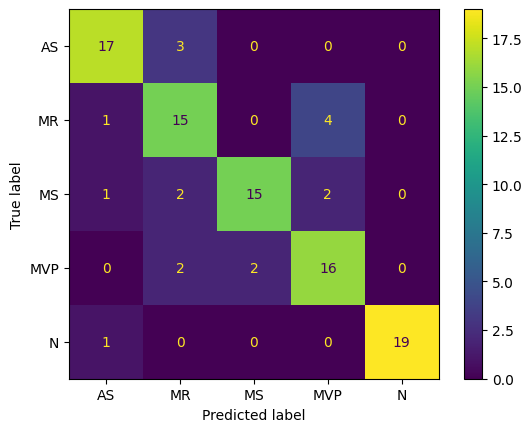

Accuracy : [0.94 0.88 0.93 0.9  0.99] mean:  0.9279999999999999
Precision : [0.85       0.68181818 0.88235294 0.72727273 1.        ] mean:  0.828288770053476
Sensitivity : [0.85 0.75 0.75 0.8  0.95] mean:  0.8200000000000001
Specificity : [0.9625 0.9125 0.975  0.925  1.    ] mean:  0.9550000000000001
f1_score: [0.85       0.71428571 0.81081081 0.76190476 0.97435897] mean:  0.8222720522720521



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb3L8.csv_4.h5
4/4 [==============================] - 0s 8ms/step


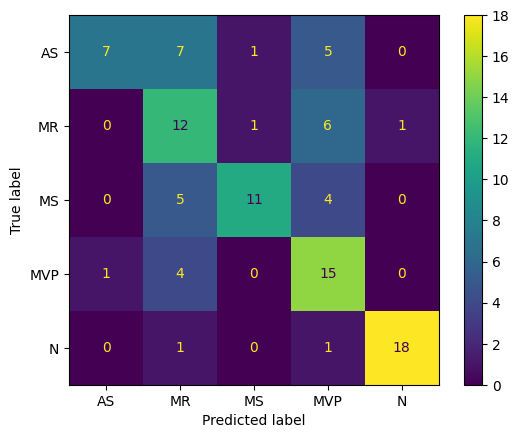

Accuracy : [0.86 0.75 0.89 0.79 0.97] mean:  0.852
Precision : [0.875      0.4137931  0.84615385 0.48387097 0.94736842] mean:  0.7132372676793378
Sensitivity : [0.35 0.6  0.55 0.75 0.9 ] mean:  0.63
Specificity : [0.9875 0.7875 0.975  0.8    0.9875] mean:  0.9075
f1_score: [0.5        0.48979592 0.66666667 0.58823529 0.92307692] mean:  0.6335549604457167



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb3L9.csv_2.h5
4/4 [==============================] - 0s 12ms/step


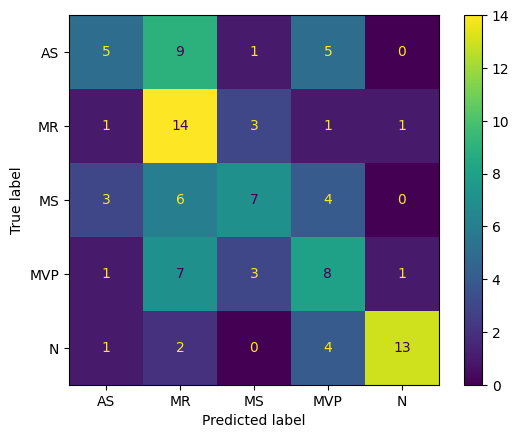

Accuracy : [0.79 0.7  0.8  0.74 0.91] mean:  0.788
Precision : [0.45454545 0.36842105 0.5        0.36363636 0.86666667] mean:  0.5106539074960128
Sensitivity : [0.25 0.7  0.35 0.4  0.65] mean:  0.4699999999999999
Specificity : [0.925  0.7    0.9125 0.825  0.975 ] mean:  0.8674999999999999
f1_score: [0.32258065 0.48275862 0.41176471 0.38095238 0.74285714] mean:  0.46818269910856447



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb3L10.csv_4.h5
4/4 [==============================] - 0s 8ms/step


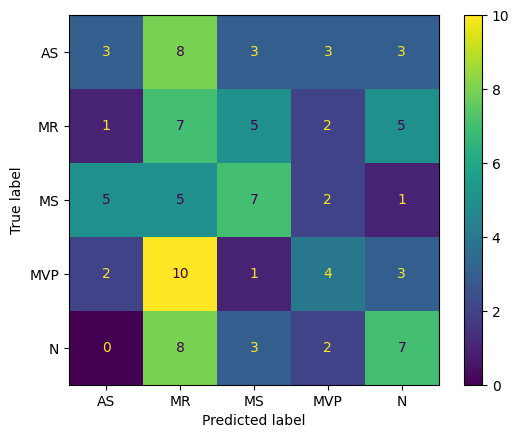

Accuracy : [0.75 0.56 0.75 0.75 0.75] mean:  0.712
Precision : [0.27272727 0.18421053 0.36842105 0.30769231 0.36842105] mean:  0.30029444239970554
Sensitivity : [0.15 0.35 0.35 0.2  0.35] mean:  0.27999999999999997
Specificity : [0.9    0.6125 0.85   0.8875 0.85  ] mean:  0.82
f1_score: [0.19354839 0.24137931 0.35897436 0.24242424 0.35897436] mean:  0.27906013156291243



Accuracy All : [0.952, 0.976, 0.984, 0.96, 0.9359999999999999, 0.9560000000000001, 0.9279999999999999, 0.852, 0.788, 0.712]
Precision All : [0.881096681096681, 0.9431533378901801, 0.9614285714285714, 0.9046567826215155, 0.8804166666666667, 0.9007312252964427, 0.828288770053476, 0.7132372676793378, 0.5106539074960128, 0.30029444239970554]
Sensitivity All : [0.8799999999999999, 0.9399999999999998, 0.96, 0.9, 0.8400000000000001, 0.89, 0.8200000000000001, 0.63, 0.4699999999999999, 0.27999999999999997]
Specificity All : [0.97, 0.985, 0.99, 0.975, 0.9600000000000002, 0.9725000000000001, 0.9550000000000001, 0.9075, 0.8674999

In [9]:
testingVHD(a3, 3)

Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb4L1.csv_3.h5


4/4 [==============================] - 0s 9ms/step


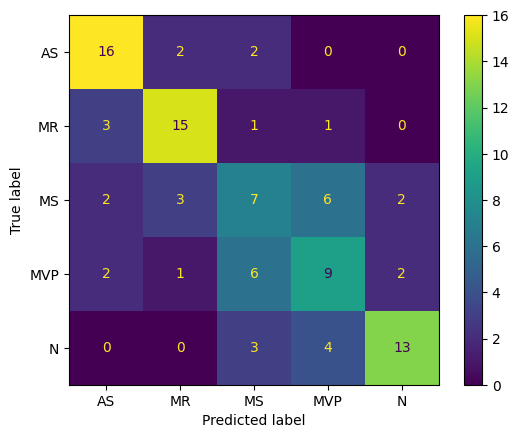

Accuracy : [0.89 0.89 0.75 0.78 0.89] mean:  0.8400000000000001
Precision : [0.69565217 0.71428571 0.36842105 0.45       0.76470588] mean:  0.5986129646366556
Sensitivity : [0.8  0.75 0.35 0.45 0.65] mean:  0.6
Specificity : [0.9125 0.925  0.85   0.8625 0.95  ] mean:  0.9
f1_score: [0.74418605 0.73170732 0.35897436 0.45       0.7027027 ] mean:  0.597514085052372



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb4L2.csv_5.h5
4/4 [==============================] - 0s 8ms/step


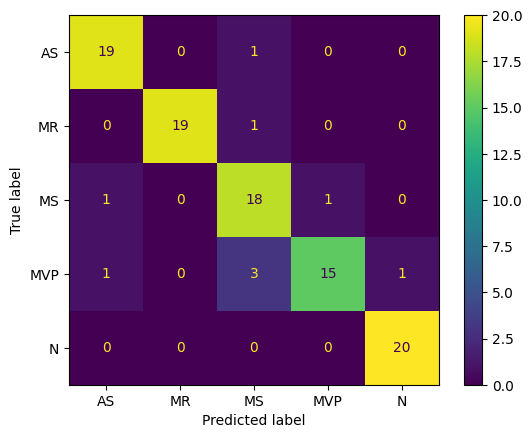

Accuracy : [0.97 0.99 0.93 0.94 0.99] mean:  0.9640000000000001
Precision : [0.9047619  1.         0.7826087  0.9375     0.95238095] mean:  0.9154503105590062
Sensitivity : [0.95 0.95 0.9  0.75 1.  ] mean:  0.9099999999999999
Specificity : [0.975  1.     0.9375 0.9875 0.9875] mean:  0.9775
f1_score: [0.92682927 0.97435897 0.8372093  0.83333333 0.97560976] mean:  0.9094681268816267



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb4L3.csv_2.h5
4/4 [==============================] - 0s 8ms/step


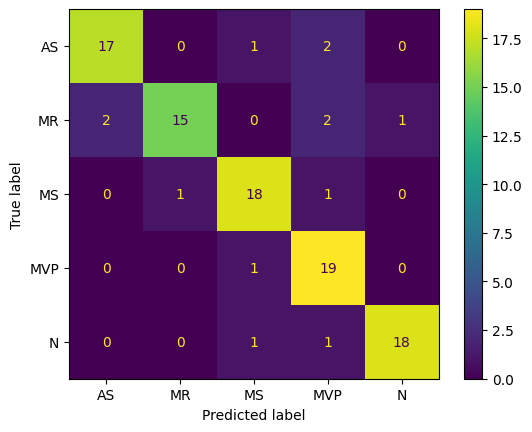

Accuracy : [0.95 0.94 0.95 0.93 0.97] mean:  0.9480000000000001
Precision : [0.89473684 0.9375     0.85714286 0.76       0.94736842] mean:  0.8793496240601504
Sensitivity : [0.85 0.75 0.9  0.95 0.9 ] mean:  0.8700000000000001
Specificity : [0.975  0.9875 0.9625 0.925  0.9875] mean:  0.9674999999999999
f1_score: [0.87179487 0.83333333 0.87804878 0.84444444 0.92307692] mean:  0.8701396706274755



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb4L4.csv_2.h5
4/4 [==============================] - 0s 7ms/step


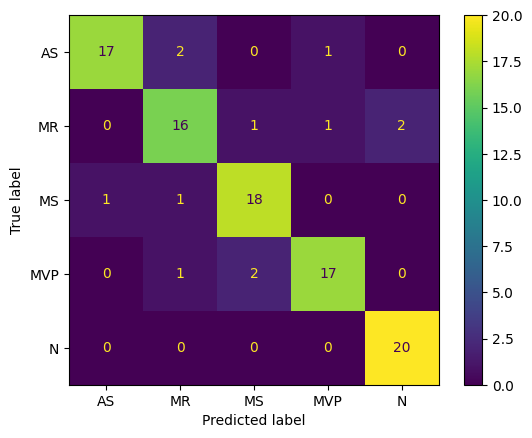

Accuracy : [0.96 0.92 0.95 0.95 0.98] mean:  0.952
Precision : [0.94444444 0.8        0.85714286 0.89473684 0.90909091] mean:  0.8810830105566948
Sensitivity : [0.85 0.8  0.9  0.85 1.  ] mean:  0.8800000000000001
Specificity : [0.9875 0.95   0.9625 0.975  0.975 ] mean:  0.97
f1_score: [0.89473684 0.8        0.87804878 0.87179487 0.95238095] mean:  0.8793922893537784



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb4L5.csv_4.h5
4/4 [==============================] - 0s 8ms/step


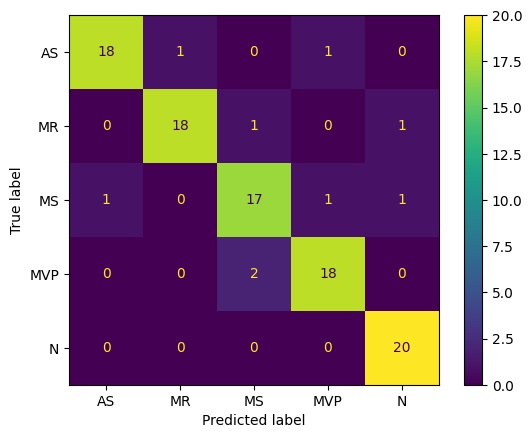

Accuracy : [0.97 0.97 0.94 0.96 0.98] mean:  0.9640000000000001
Precision : [0.94736842 0.94736842 0.85       0.9        0.90909091] mean:  0.9107655502392344
Sensitivity : [0.9  0.9  0.85 0.9  1.  ] mean:  0.9099999999999999
Specificity : [0.9875 0.9875 0.9625 0.975  0.975 ] mean:  0.9775
f1_score: [0.92307692 0.92307692 0.85       0.9        0.95238095] mean:  0.9097069597069597



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb4L6.csv_2.h5
4/4 [==============================] - 0s 8ms/step


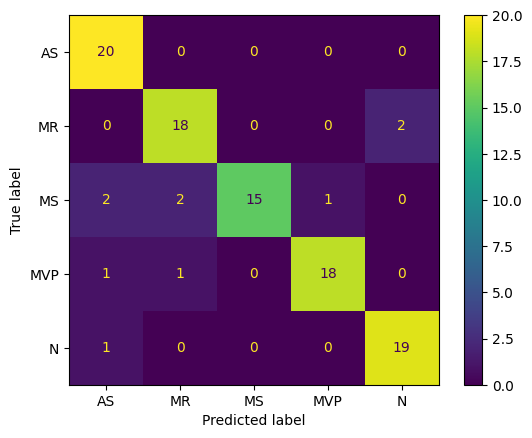

Accuracy : [0.96 0.95 0.95 0.97 0.97] mean:  0.96
Precision : [0.83333333 0.85714286 1.         0.94736842 0.9047619 ] mean:  0.9085213032581454
Sensitivity : [1.   0.9  0.75 0.9  0.95] mean:  0.9
Specificity : [0.95   0.9625 1.     0.9875 0.975 ] mean:  0.975
f1_score: [0.90909091 0.87804878 0.85714286 0.92307692 0.92682927] mean:  0.8988377476182354



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb4L7.csv_5.h5
4/4 [==============================] - 0s 10ms/step


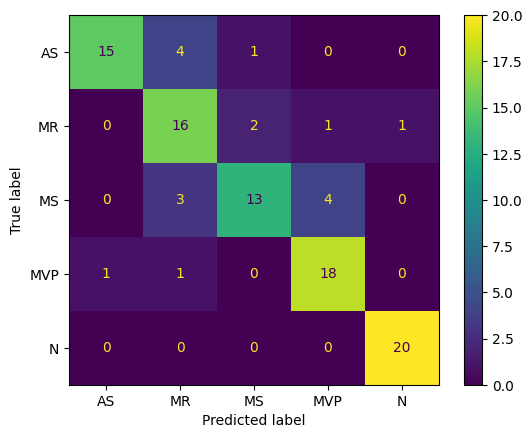

Accuracy : [0.94 0.88 0.9  0.93 0.99] mean:  0.9279999999999999
Precision : [0.9375     0.66666667 0.8125     0.7826087  0.95238095] mean:  0.8303312629399585
Sensitivity : [0.75 0.8  0.65 0.9  1.  ] mean:  0.82
Specificity : [0.9875 0.9    0.9625 0.9375 0.9875] mean:  0.9550000000000001
f1_score: [0.83333333 0.72727273 0.72222222 0.8372093  0.97560976] mean:  0.819129468250285



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb4L8.csv_3.h5
4/4 [==============================] - 0s 9ms/step


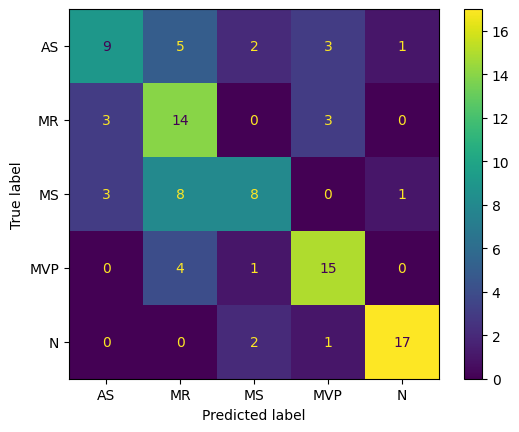

Accuracy : [0.83 0.77 0.83 0.88 0.95] mean:  0.852
Precision : [0.6        0.4516129  0.61538462 0.68181818 0.89473684] mean:  0.6487105085067734
Sensitivity : [0.45 0.7  0.4  0.75 0.85] mean:  0.63
Specificity : [0.925  0.7875 0.9375 0.9125 0.975 ] mean:  0.9075
f1_score: [0.51428571 0.54901961 0.48484848 0.71428571 0.87179487] mean:  0.6268468786115845



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb4L9.csv_2.h5
4/4 [==============================] - 0s 8ms/step


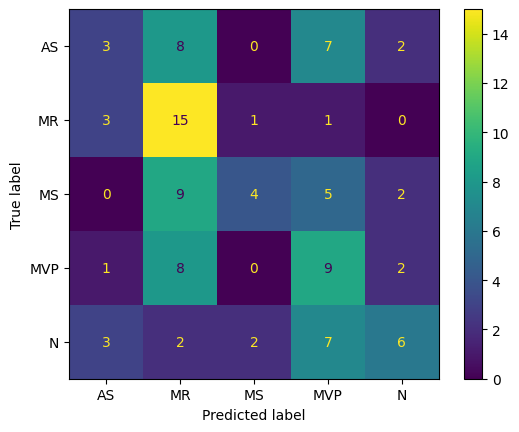

Accuracy : [0.76 0.68 0.81 0.69 0.8 ] mean:  0.748
Precision : [0.3        0.35714286 0.57142857 0.31034483 0.5       ] mean:  0.4077832512315271
Sensitivity : [0.15 0.75 0.2  0.45 0.3 ] mean:  0.37
Specificity : [0.9125 0.6625 0.9625 0.75   0.925 ] mean:  0.8425
f1_score: [0.2        0.48387097 0.2962963  0.36734694 0.375     ] mean:  0.3445028405627484



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb4L10.csv_2.h5
4/4 [==============================] - 0s 8ms/step


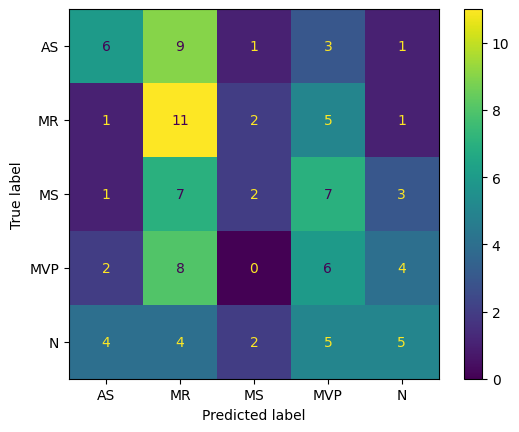

Accuracy : [0.78 0.63 0.77 0.66 0.76] mean:  0.7200000000000001
Precision : [0.42857143 0.28205128 0.28571429 0.23076923 0.35714286] mean:  0.31684981684981683
Sensitivity : [0.3  0.55 0.1  0.3  0.25] mean:  0.3
Specificity : [0.9    0.65   0.9375 0.75   0.8875] mean:  0.825
f1_score: [0.35294118 0.37288136 0.14814815 0.26086957 0.29411765] mean:  0.2857915785654309



Accuracy All : [0.8400000000000001, 0.9640000000000001, 0.9480000000000001, 0.952, 0.9640000000000001, 0.96, 0.9279999999999999, 0.852, 0.748, 0.7200000000000001]
Precision All : [0.5986129646366556, 0.9154503105590062, 0.8793496240601504, 0.8810830105566948, 0.9107655502392344, 0.9085213032581454, 0.8303312629399585, 0.6487105085067734, 0.4077832512315271, 0.31684981684981683]
Sensitivity All : [0.6, 0.9099999999999999, 0.8700000000000001, 0.8800000000000001, 0.9099999999999999, 0.9, 0.82, 0.63, 0.37, 0.3]
Specificity All : [0.9, 0.9775, 0.9674999999999999, 0.97, 0.9775, 0.975, 0.9550000000000001, 0.9075, 0.8425, 0.825]

In [10]:
testingVHD(a4, 4)

Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb5L1.csv_5.h5


4/4 [==============================] - 0s 9ms/step


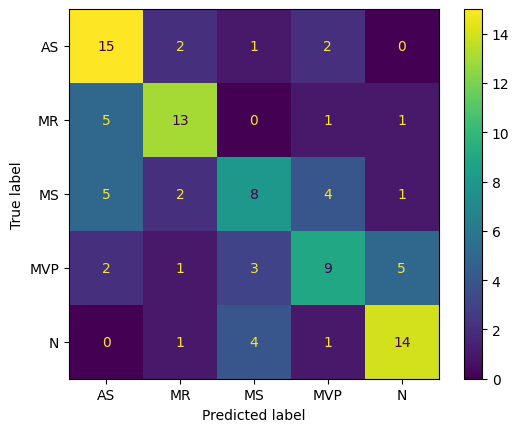

Accuracy : [0.83 0.87 0.8  0.81 0.87] mean:  0.836
Precision : [0.55555556 0.68421053 0.5        0.52941176 0.66666667] mean:  0.5871689026487787
Sensitivity : [0.75 0.65 0.4  0.45 0.7 ] mean:  0.5900000000000001
Specificity : [0.85   0.925  0.9    0.9    0.9125] mean:  0.8975
f1_score: [0.63829787 0.66666667 0.44444444 0.48648649 0.68292683] mean:  0.5837644598412632



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb5L2.csv_5.h5
4/4 [==============================] - 0s 8ms/step


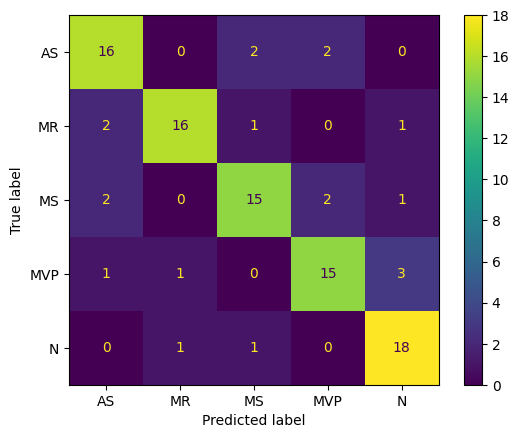

Accuracy : [0.91 0.94 0.91 0.91 0.93] mean:  0.9200000000000002
Precision : [0.76190476 0.88888889 0.78947368 0.78947368 0.7826087 ] mean:  0.8024699429733755
Sensitivity : [0.8  0.8  0.75 0.75 0.9 ] mean:  0.8
Specificity : [0.9375 0.975  0.95   0.95   0.9375] mean:  0.95
f1_score: [0.7804878  0.84210526 0.76923077 0.76923077 0.8372093 ] mean:  0.7996527817646127



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb5L3.csv_2.h5
4/4 [==============================] - 0s 8ms/step


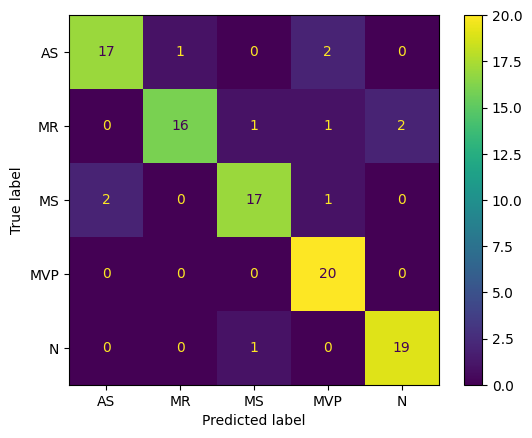

Accuracy : [0.95 0.95 0.95 0.96 0.97] mean:  0.9559999999999998
Precision : [0.89473684 0.94117647 0.89473684 0.83333333 0.9047619 ] mean:  0.8937490785788
Sensitivity : [0.85 0.8  0.85 1.   0.95] mean:  0.89
Specificity : [0.975  0.9875 0.975  0.95   0.975 ] mean:  0.9724999999999999
f1_score: [0.87179487 0.86486486 0.87179487 0.90909091 0.92682927] mean:  0.8888749571676401



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb5L4.csv_5.h5
4/4 [==============================] - 0s 8ms/step


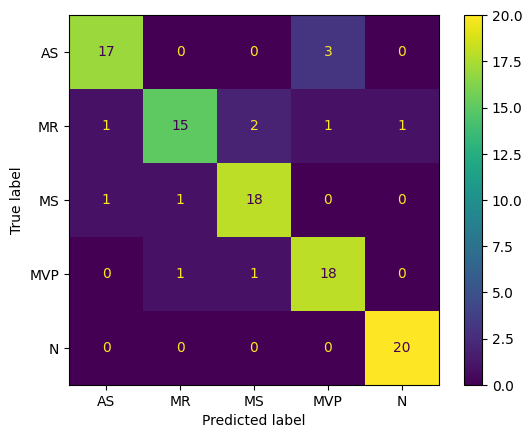

Accuracy : [0.95 0.93 0.95 0.94 0.99] mean:  0.952
Precision : [0.89473684 0.88235294 0.85714286 0.81818182 0.95238095] mean:  0.8809590821974723
Sensitivity : [0.85 0.75 0.9  0.9  1.  ] mean:  0.8800000000000001
Specificity : [0.975  0.975  0.9625 0.95   0.9875] mean:  0.97
f1_score: [0.87179487 0.81081081 0.87804878 0.85714286 0.97560976] mean:  0.8786814152667812



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb5L5.csv_5.h5
4/4 [==============================] - 0s 9ms/step


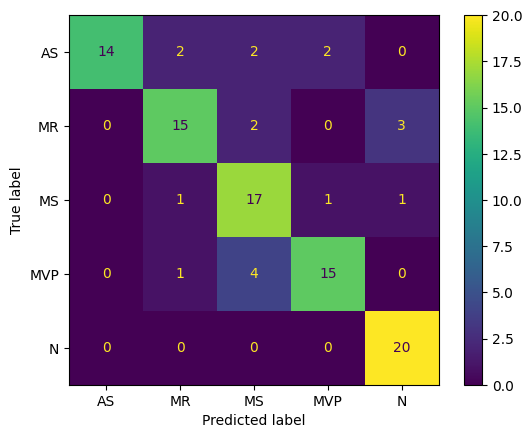

Accuracy : [0.94 0.91 0.89 0.92 0.96] mean:  0.924
Precision : [1.         0.78947368 0.68       0.83333333 0.83333333] mean:  0.8272280701754386
Sensitivity : [0.7  0.75 0.85 0.75 1.  ] mean:  0.8099999999999999
Specificity : [1.     0.95   0.9    0.9625 0.95  ] mean:  0.9525
f1_score: [0.82352941 0.76923077 0.75555556 0.78947368 0.90909091] mean:  0.8093760659704932



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb5L6.csv_5.h5
4/4 [==============================] - 0s 8ms/step


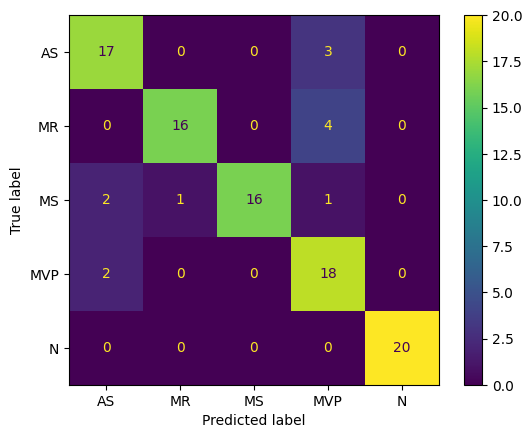

Accuracy : [0.93 0.95 0.96 0.9  1.  ] mean:  0.9480000000000001
Precision : [0.80952381 0.94117647 1.         0.69230769 1.        ] mean:  0.8886015944839475
Sensitivity : [0.85 0.8  0.8  0.9  1.  ] mean:  0.8699999999999999
Specificity : [0.95   0.9875 1.     0.9    1.    ] mean:  0.9675
f1_score: [0.82926829 0.86486486 0.88888889 0.7826087  1.        ] mean:  0.8731261484177708



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb5L7.csv_2.h5
4/4 [==============================] - 0s 11ms/step


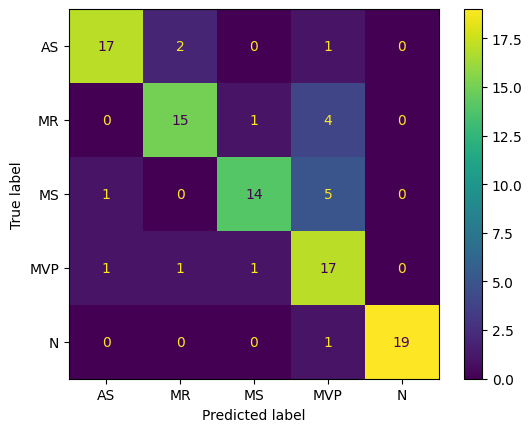

Accuracy : [0.95 0.92 0.92 0.86 0.99] mean:  0.9279999999999999
Precision : [0.89473684 0.83333333 0.875      0.60714286 1.        ] mean:  0.8420426065162907
Sensitivity : [0.85 0.75 0.7  0.85 0.95] mean:  0.82
Specificity : [0.975  0.9625 0.975  0.8625 1.    ] mean:  0.9550000000000001
f1_score: [0.87179487 0.78947368 0.77777778 0.70833333 0.97435897] mean:  0.8243477282950966



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb5L8.csv_5.h5
4/4 [==============================] - 0s 9ms/step


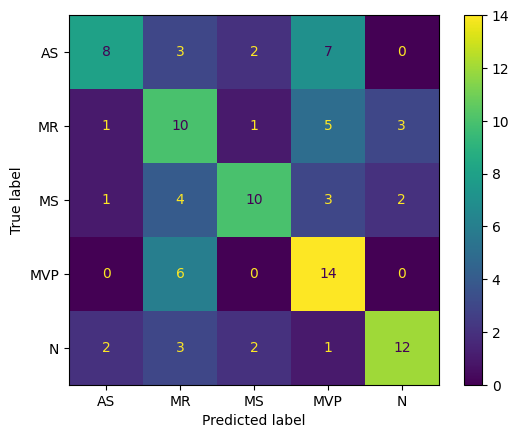

Accuracy : [0.84 0.74 0.85 0.78 0.87] mean:  0.8160000000000001
Precision : [0.66666667 0.38461538 0.66666667 0.46666667 0.70588235] mean:  0.5780995475113123
Sensitivity : [0.4 0.5 0.5 0.7 0.6] mean:  0.5399999999999999
Specificity : [0.95   0.8    0.9375 0.8    0.9375] mean:  0.885
f1_score: [0.5        0.43478261 0.57142857 0.56       0.64864865] mean:  0.5429719657545745



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb5L9.csv_5.h5
4/4 [==============================] - 0s 8ms/step


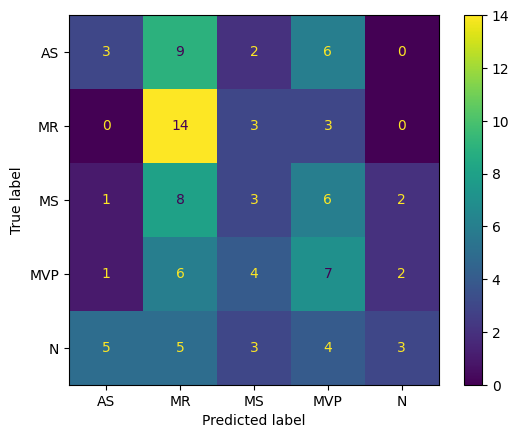

Accuracy : [0.76 0.66 0.71 0.68 0.79] mean:  0.72
Precision : [0.3        0.33333333 0.2        0.26923077 0.42857143] mean:  0.3062271062271062
Sensitivity : [0.15 0.7  0.15 0.35 0.15] mean:  0.3
Specificity : [0.9125 0.65   0.85   0.7625 0.95  ] mean:  0.825
f1_score: [0.2        0.4516129  0.17142857 0.30434783 0.22222222] mean:  0.2699223045927114



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb5L10.csv_2.h5
4/4 [==============================] - 0s 8ms/step


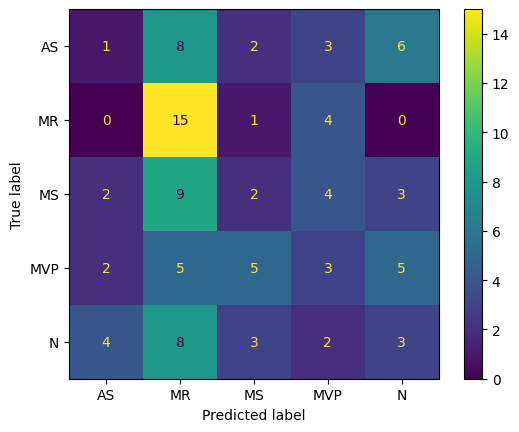

Accuracy : [0.73 0.65 0.71 0.7  0.69] mean:  0.696
Precision : [0.11111111 0.33333333 0.15384615 0.1875     0.17647059] mean:  0.1924522373051785
Sensitivity : [0.05 0.75 0.1  0.15 0.15] mean:  0.24
Specificity : [0.9    0.625  0.8625 0.8375 0.825 ] mean:  0.8099999999999999
f1_score: [0.06896552 0.46153846 0.12121212 0.16666667 0.16216216] mean:  0.1961089857641582



Accuracy All : [0.836, 0.9200000000000002, 0.9559999999999998, 0.952, 0.924, 0.9480000000000001, 0.9279999999999999, 0.8160000000000001, 0.72, 0.696]
Precision All : [0.5871689026487787, 0.8024699429733755, 0.8937490785788, 0.8809590821974723, 0.8272280701754386, 0.8886015944839475, 0.8420426065162907, 0.5780995475113123, 0.3062271062271062, 0.1924522373051785]
Sensitivity All : [0.5900000000000001, 0.8, 0.89, 0.8800000000000001, 0.8099999999999999, 0.8699999999999999, 0.82, 0.5399999999999999, 0.3, 0.24]
Specificity All : [0.8975, 0.95, 0.9724999999999999, 0.97, 0.9525, 0.9675, 0.9550000000000001, 0.885, 0.825, 0.809999

In [11]:
testingVHD(a5, 5)

Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb6L1.csv_3.h5


4/4 [==============================] - 1s 9ms/step


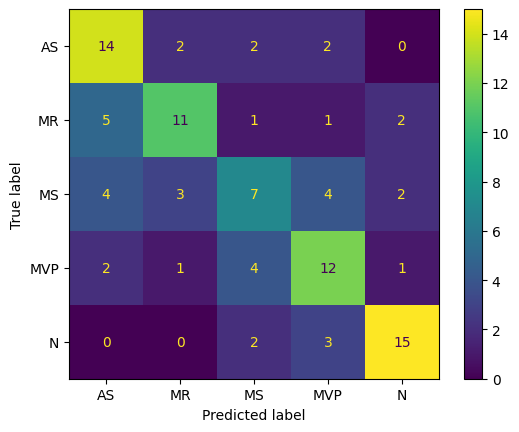

Accuracy : [0.83 0.85 0.78 0.82 0.9 ] mean:  0.836
Precision : [0.56       0.64705882 0.4375     0.54545455 0.75      ] mean:  0.5880026737967914
Sensitivity : [0.7  0.55 0.35 0.6  0.75] mean:  0.5900000000000001
Specificity : [0.8625 0.925  0.8875 0.875  0.9375] mean:  0.8975
f1_score: [0.62222222 0.59459459 0.38888889 0.57142857 0.75      ] mean:  0.5854268554268554



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb6L2.csv_4.h5
4/4 [==============================] - 0s 11ms/step


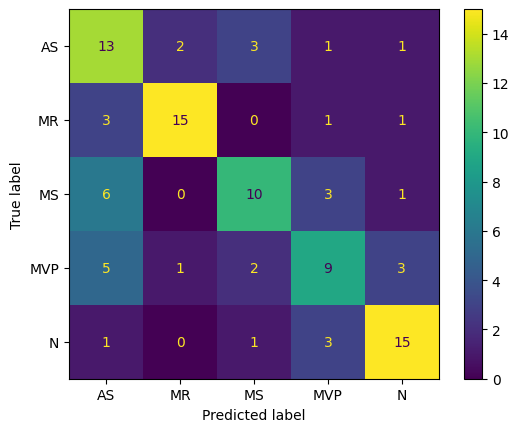

Accuracy : [0.78 0.92 0.84 0.81 0.89] mean:  0.8480000000000001
Precision : [0.46428571 0.83333333 0.625      0.52941176 0.71428571] mean:  0.6332633053221289
Sensitivity : [0.65 0.75 0.5  0.45 0.75] mean:  0.62
Specificity : [0.8125 0.9625 0.925  0.9    0.925 ] mean:  0.905
f1_score: [0.54166667 0.78947368 0.55555556 0.48648649 0.73170732] mean:  0.6209779419984811



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb6L3.csv_2.h5
4/4 [==============================] - 0s 8ms/step


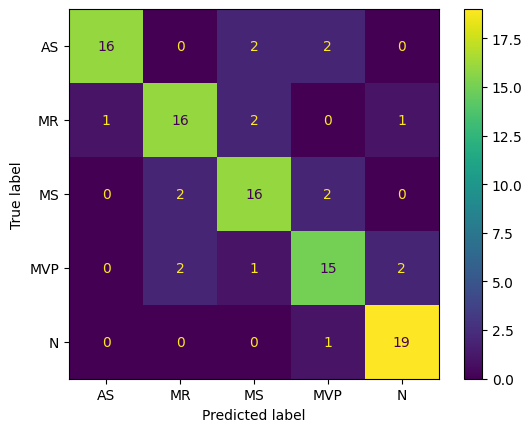

Accuracy : [0.95 0.92 0.91 0.9  0.96] mean:  0.9280000000000002
Precision : [0.94117647 0.8        0.76190476 0.75       0.86363636] mean:  0.8233435192258721
Sensitivity : [0.8  0.8  0.8  0.75 0.95] mean:  0.8200000000000001
Specificity : [0.9875 0.95   0.9375 0.9375 0.9625] mean:  0.9550000000000001
f1_score: [0.86486486 0.8        0.7804878  0.75       0.9047619 ] mean:  0.8200229149009637



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb6L4.csv_5.h5
4/4 [==============================] - 1s 8ms/step


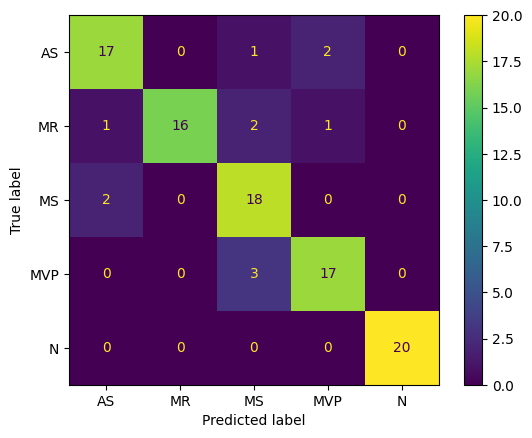

Accuracy : [0.94 0.96 0.92 0.94 1.  ] mean:  0.952
Precision : [0.85 1.   0.75 0.85 1.  ] mean:  0.89
Sensitivity : [0.85 0.8  0.9  0.85 1.  ] mean:  0.8800000000000001
Specificity : [0.9625 1.     0.925  0.9625 1.    ] mean:  0.97
f1_score: [0.85       0.88888889 0.81818182 0.85       1.        ] mean:  0.8814141414141414



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb6L5.csv_2.h5
4/4 [==============================] - 0s 10ms/step


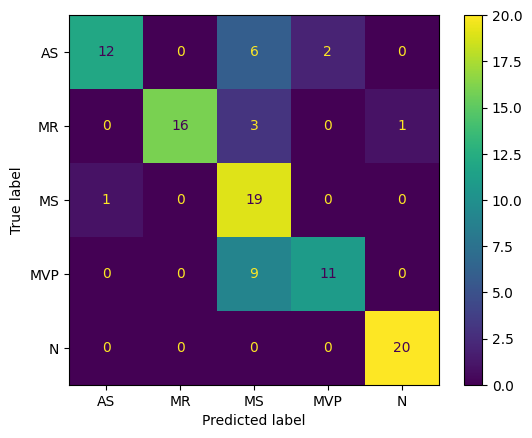

Accuracy : [0.91 0.96 0.81 0.89 0.99] mean:  0.9120000000000001
Precision : [0.92307692 1.         0.51351351 0.84615385 0.95238095] mean:  0.847025047025047
Sensitivity : [0.6  0.8  0.95 0.55 1.  ] mean:  0.7799999999999999
Specificity : [0.9875 1.     0.775  0.975  0.9875] mean:  0.9450000000000001
f1_score: [0.72727273 0.88888889 0.66666667 0.66666667 0.97560976] mean:  0.7850209411185022



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb6L6.csv_2.h5
4/4 [==============================] - 0s 8ms/step


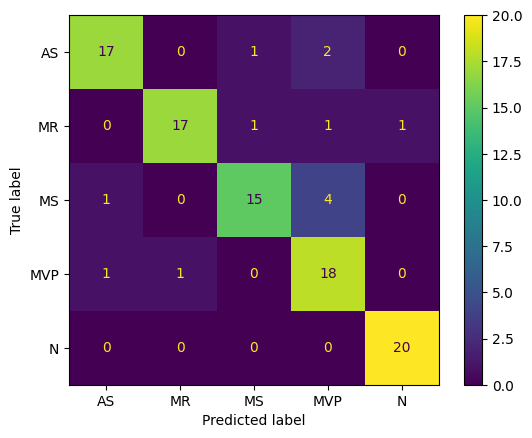

Accuracy : [0.95 0.96 0.93 0.91 0.99] mean:  0.9480000000000001
Precision : [0.89473684 0.94444444 0.88235294 0.72       0.95238095] mean:  0.8787830360214262
Sensitivity : [0.85 0.85 0.75 0.9  1.  ] mean:  0.8699999999999999
Specificity : [0.975  0.9875 0.975  0.9125 0.9875] mean:  0.9675
f1_score: [0.87179487 0.89473684 0.81081081 0.8        0.97560976] mean:  0.8705904561617013



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb6L7.csv_5.h5
4/4 [==============================] - 1s 10ms/step


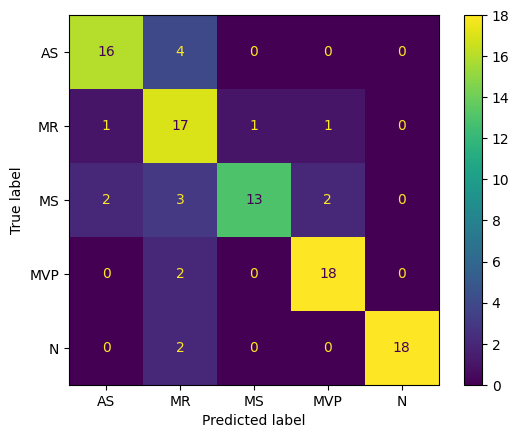

Accuracy : [0.93 0.86 0.92 0.95 0.98] mean:  0.9280000000000002
Precision : [0.84210526 0.60714286 0.92857143 0.85714286 1.        ] mean:  0.8469924812030076
Sensitivity : [0.8  0.85 0.65 0.9  0.9 ] mean:  0.82
Specificity : [0.9625 0.8625 0.9875 0.9625 1.    ] mean:  0.9550000000000001
f1_score: [0.82051282 0.70833333 0.76470588 0.87804878 0.94736842] mean:  0.8237938475479062



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb6L8.csv_4.h5
4/4 [==============================] - 0s 9ms/step


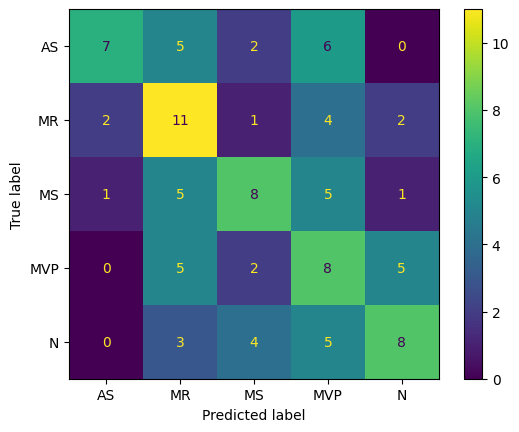

Accuracy : [0.84 0.73 0.79 0.68 0.8 ] mean:  0.768
Precision : [0.7        0.37931034 0.47058824 0.28571429 0.5       ] mean:  0.46712257316719785
Sensitivity : [0.35 0.55 0.4  0.4  0.4 ] mean:  0.42000000000000004
Specificity : [0.9625 0.775  0.8875 0.75   0.9   ] mean:  0.8550000000000001
f1_score: [0.46666667 0.44897959 0.43243243 0.33333333 0.44444444] mean:  0.42517129374272233



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb6L9.csv_3.h5
4/4 [==============================] - 0s 8ms/step


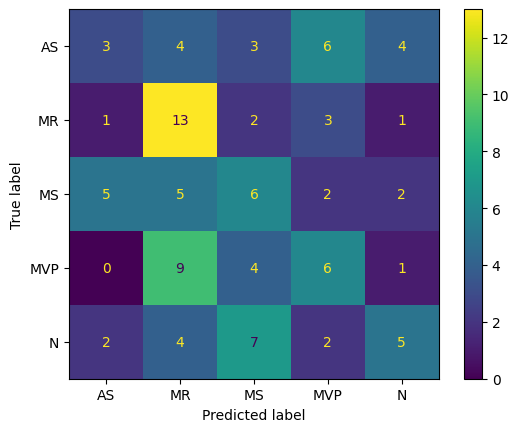

Accuracy : [0.75 0.71 0.7  0.73 0.77] mean:  0.732
Precision : [0.27272727 0.37142857 0.27272727 0.31578947 0.38461538] mean:  0.3234575950365424
Sensitivity : [0.15 0.65 0.3  0.3  0.25] mean:  0.33
Specificity : [0.9    0.725  0.8    0.8375 0.9   ] mean:  0.8324999999999999
f1_score: [0.19354839 0.47272727 0.28571429 0.30769231 0.3030303 ] mean:  0.3125425112521886



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb6L10.csv_3.h5
4/4 [==============================] - 1s 10ms/step


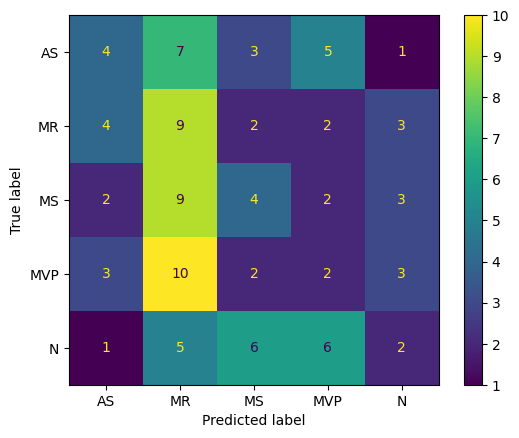

Accuracy : [0.74 0.58 0.71 0.67 0.72] mean:  0.6839999999999999
Precision : [0.28571429 0.225      0.23529412 0.11764706 0.16666667] mean:  0.20606442577030815
Sensitivity : [0.2  0.45 0.2  0.1  0.1 ] mean:  0.21000000000000002
Specificity : [0.875  0.6125 0.8375 0.8125 0.875 ] mean:  0.8025
f1_score: [0.23529412 0.3        0.21621622 0.10810811 0.125     ] mean:  0.19692368839427662



Accuracy All : [0.836, 0.8480000000000001, 0.9280000000000002, 0.952, 0.9120000000000001, 0.9480000000000001, 0.9280000000000002, 0.768, 0.732, 0.6839999999999999]
Precision All : [0.5880026737967914, 0.6332633053221289, 0.8233435192258721, 0.89, 0.847025047025047, 0.8787830360214262, 0.8469924812030076, 0.46712257316719785, 0.3234575950365424, 0.20606442577030815]
Sensitivity All : [0.5900000000000001, 0.62, 0.8200000000000001, 0.8800000000000001, 0.7799999999999999, 0.8699999999999999, 0.82, 0.42000000000000004, 0.33, 0.21000000000000002]
Specificity All : [0.8975, 0.905, 0.9550000000000001, 0.97, 0.9

In [12]:
testingVHD(a6, 6)

Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb7L1.csv_2.h5
4/4 [==============================] - 1s 9ms/step


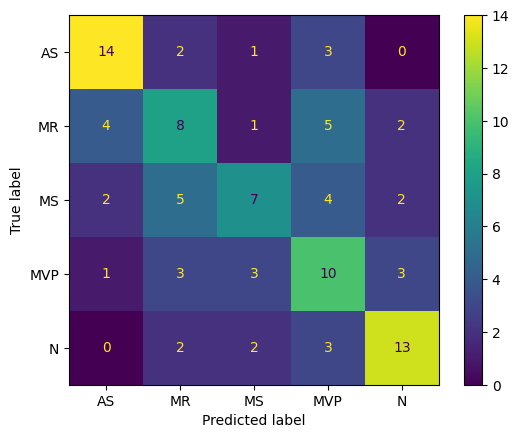

Accuracy : [0.87 0.76 0.8  0.75 0.86] mean:  0.808
Precision : [0.66666667 0.4        0.5        0.4        0.65      ] mean:  0.5233333333333333
Sensitivity : [0.7  0.4  0.35 0.5  0.65] mean:  0.52
Specificity : [0.9125 0.85   0.9125 0.8125 0.9125] mean:  0.8799999999999999
f1_score: [0.68292683 0.4        0.41176471 0.44444444 0.65      ] mean:  0.517827195919018



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb7L2.csv_3.h5
4/4 [==============================] - 1s 10ms/step


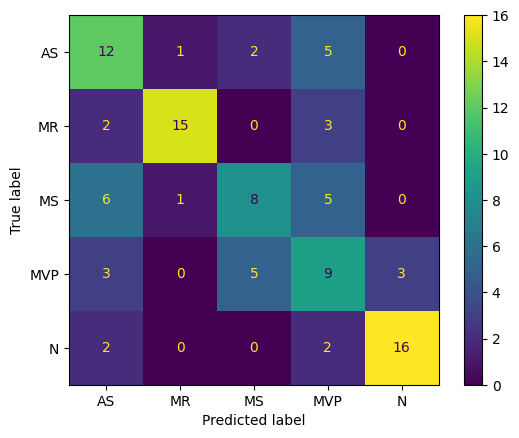

Accuracy : [0.79 0.93 0.81 0.74 0.93] mean:  0.8400000000000001
Precision : [0.48       0.88235294 0.53333333 0.375      0.84210526] mean:  0.6225583075335397
Sensitivity : [0.6  0.75 0.4  0.45 0.8 ] mean:  0.6
Specificity : [0.8375 0.975  0.9125 0.8125 0.9625] mean:  0.9
f1_score: [0.53333333 0.81081081 0.45714286 0.40909091 0.82051282] mean:  0.6061781461781461



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb7L3.csv_5.h5
4/4 [==============================] - 0s 10ms/step


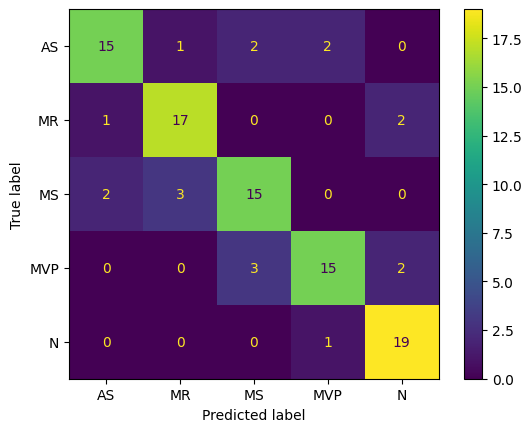

Accuracy : [0.92 0.93 0.9  0.92 0.95] mean:  0.924
Precision : [0.83333333 0.80952381 0.75       0.83333333 0.82608696] mean:  0.8104554865424431
Sensitivity : [0.75 0.85 0.75 0.75 0.95] mean:  0.8099999999999999
Specificity : [0.9625 0.95   0.9375 0.9625 0.95  ] mean:  0.9525
f1_score: [0.78947368 0.82926829 0.75       0.78947368 0.88372093] mean:  0.8083873182673076



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb7L4.csv_5.h5
4/4 [==============================] - 0s 9ms/step


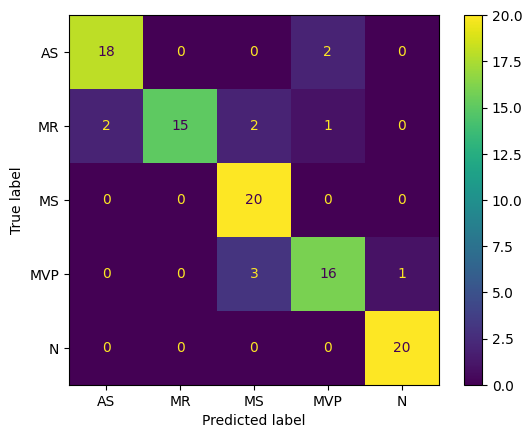

Accuracy : [0.96 0.95 0.95 0.93 0.99] mean:  0.9560000000000001
Precision : [0.9        1.         0.8        0.84210526 0.95238095] mean:  0.8988972431077695
Sensitivity : [0.9  0.75 1.   0.8  1.  ] mean:  0.89
Specificity : [0.975  1.     0.9375 0.9625 0.9875] mean:  0.9724999999999999
f1_score: [0.9        0.85714286 0.88888889 0.82051282 0.97560976] mean:  0.8884308645284256



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb7L5.csv_5.h5
4/4 [==============================] - 0s 9ms/step


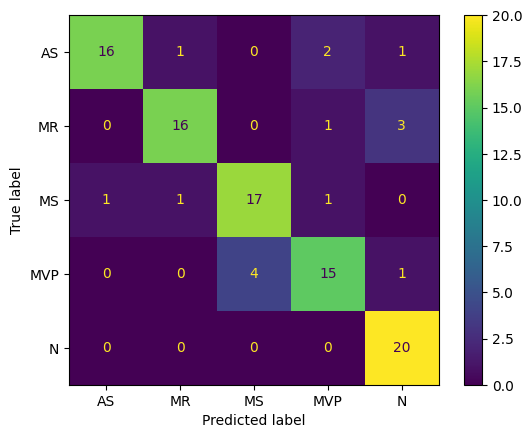

Accuracy : [0.95 0.94 0.93 0.91 0.95] mean:  0.9359999999999999
Precision : [0.94117647 0.88888889 0.80952381 0.78947368 0.8       ] mean:  0.8458125706422919
Sensitivity : [0.8  0.8  0.85 0.75 1.  ] mean:  0.8400000000000001
Specificity : [0.9875 0.975  0.95   0.95   0.9375] mean:  0.96
f1_score: [0.86486486 0.84210526 0.82926829 0.76923077 0.88888889] mean:  0.838871615765069



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb7L6.csv_2.h5
4/4 [==============================] - 0s 9ms/step


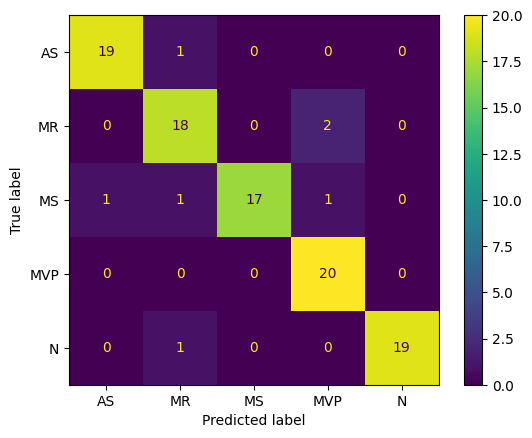

Accuracy : [0.98 0.95 0.97 0.97 0.99] mean:  0.9720000000000001
Precision : [0.95       0.85714286 1.         0.86956522 1.        ] mean:  0.9353416149068323
Sensitivity : [0.95 0.9  0.85 1.   0.95] mean:  0.93
Specificity : [0.9875 0.9625 1.     0.9625 1.    ] mean:  0.9824999999999999
f1_score: [0.95       0.87804878 0.91891892 0.93023256 0.97435897] mean:  0.9303118463810465



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb7L7.csv_2.h5
4/4 [==============================] - 0s 8ms/step


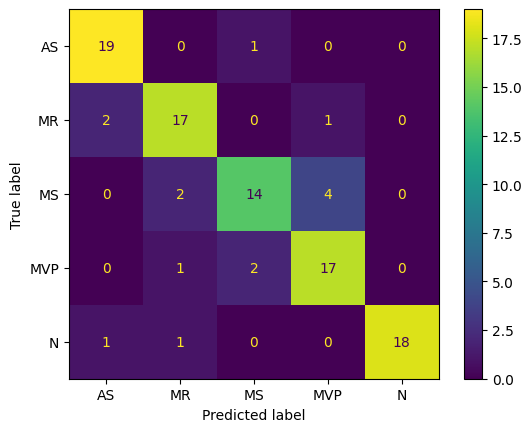

Accuracy : [0.96 0.93 0.91 0.92 0.98] mean:  0.9400000000000001
Precision : [0.86363636 0.80952381 0.82352941 0.77272727 1.        ] mean:  0.8538833715304304
Sensitivity : [0.95 0.85 0.7  0.85 0.9 ] mean:  0.85
Specificity : [0.9625 0.95   0.9625 0.9375 1.    ] mean:  0.9625
f1_score: [0.9047619  0.82926829 0.75675676 0.80952381 0.94736842] mean:  0.849535836955606



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb7L8.csv_5.h5
4/4 [==============================] - 0s 8ms/step


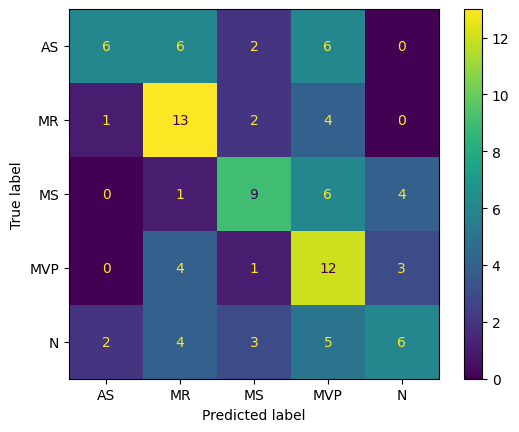

Accuracy : [0.83 0.78 0.81 0.71 0.79] mean:  0.784
Precision : [0.66666667 0.46428571 0.52941176 0.36363636 0.46153846] mean:  0.4971077941666177
Sensitivity : [0.3  0.65 0.45 0.6  0.3 ] mean:  0.45999999999999996
Specificity : [0.9625 0.8125 0.9    0.7375 0.9125] mean:  0.8649999999999999
f1_score: [0.4137931  0.54166667 0.48648649 0.45283019 0.36363636] mean:  0.4516825617834076



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb7L9.csv_1.h5
4/4 [==============================] - 0s 8ms/step


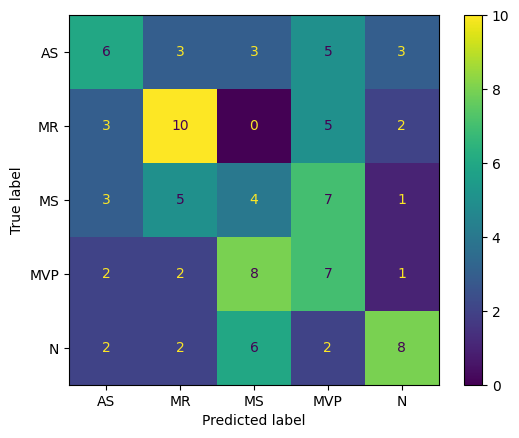

Accuracy : [0.76 0.78 0.67 0.68 0.81] mean:  0.74
Precision : [0.375      0.45454545 0.19047619 0.26923077 0.53333333] mean:  0.36451714951714953
Sensitivity : [0.3  0.5  0.2  0.35 0.4 ] mean:  0.35
Specificity : [0.875  0.85   0.7875 0.7625 0.9125] mean:  0.8375
f1_score: [0.33333333 0.47619048 0.19512195 0.30434783 0.45714286] mean:  0.3532272887946271



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb7L10.csv_1.h5
4/4 [==============================] - 0s 8ms/step


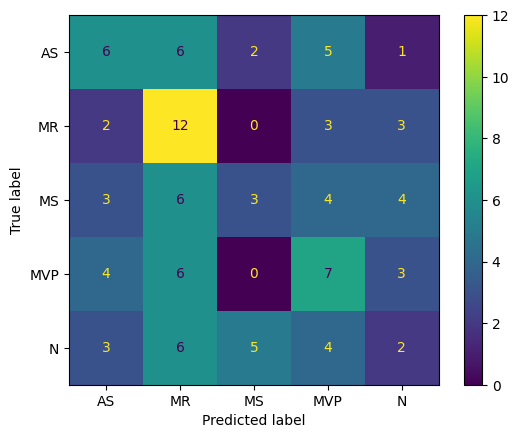

Accuracy : [0.74 0.68 0.76 0.71 0.71] mean:  0.72
Precision : [0.33333333 0.33333333 0.3        0.30434783 0.15384615] mean:  0.2849721293199554
Sensitivity : [0.3  0.6  0.15 0.35 0.1 ] mean:  0.3
Specificity : [0.85   0.7    0.9125 0.8    0.8625] mean:  0.825
f1_score: [0.31578947 0.42857143 0.2        0.3255814  0.12121212] mean:  0.2782308837633195



Accuracy All : [0.808, 0.8400000000000001, 0.924, 0.9560000000000001, 0.9359999999999999, 0.9720000000000001, 0.9400000000000001, 0.784, 0.74, 0.72]
Precision All : [0.5233333333333333, 0.6225583075335397, 0.8104554865424431, 0.8988972431077695, 0.8458125706422919, 0.9353416149068323, 0.8538833715304304, 0.4971077941666177, 0.36451714951714953, 0.2849721293199554]
Sensitivity All : [0.52, 0.6, 0.8099999999999999, 0.89, 0.8400000000000001, 0.93, 0.85, 0.45999999999999996, 0.35, 0.3]
Specificity All : [0.8799999999999999, 0.9, 0.9525, 0.9724999999999999, 0.96, 0.9824999999999999, 0.9625, 0.8649999999999999, 0.8375, 0.825]
f1_score All : 

In [13]:
testingVHD(a7, 7)

Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb8L1.csv_3.h5


4/4 [==============================] - 0s 8ms/step


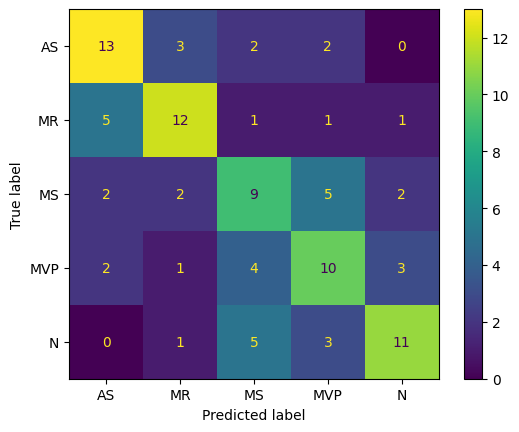

Accuracy : [0.84 0.85 0.77 0.79 0.85] mean:  0.82
Precision : [0.59090909 0.63157895 0.42857143 0.47619048 0.64705882] mean:  0.5548617533137656
Sensitivity : [0.65 0.6  0.45 0.5  0.55] mean:  0.55
Specificity : [0.8875 0.9125 0.85   0.8625 0.925 ] mean:  0.8875
f1_score: [0.61904762 0.61538462 0.43902439 0.48780488 0.59459459] mean:  0.5511712194639025



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb8L2.csv_5.h5
4/4 [==============================] - 0s 8ms/step


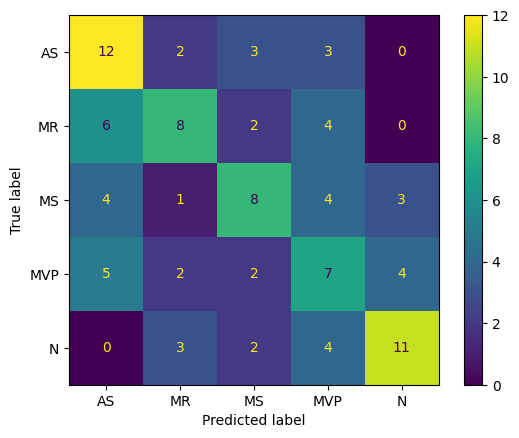

Accuracy : [0.77 0.8  0.79 0.72 0.84] mean:  0.784
Precision : [0.44444444 0.5        0.47058824 0.31818182 0.61111111] mean:  0.4688651218062983
Sensitivity : [0.6  0.4  0.4  0.35 0.55] mean:  0.45999999999999996
Specificity : [0.8125 0.9    0.8875 0.8125 0.9125] mean:  0.8649999999999999
f1_score: [0.5106383  0.44444444 0.43243243 0.33333333 0.57894737] mean:  0.4599591753007207



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb8L3.csv_2.h5
4/4 [==============================] - 0s 8ms/step


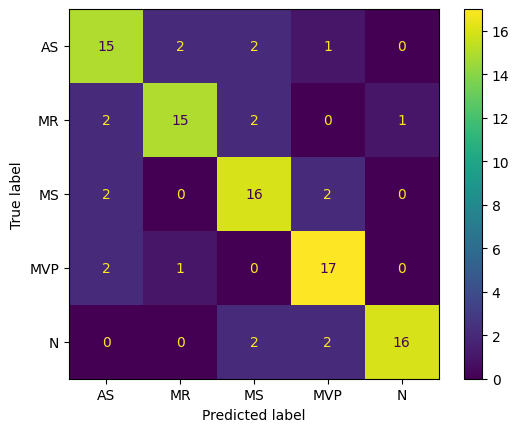

Accuracy : [0.89 0.92 0.9  0.92 0.95] mean:  0.916
Precision : [0.71428571 0.83333333 0.72727273 0.77272727 0.94117647] mean:  0.7977591036414566
Sensitivity : [0.75 0.75 0.8  0.85 0.8 ] mean:  0.79
Specificity : [0.925  0.9625 0.925  0.9375 0.9875] mean:  0.9475
f1_score: [0.73170732 0.78947368 0.76190476 0.80952381 0.86486486] mean:  0.7914948875154266



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb8L4.csv_5.h5
4/4 [==============================] - 0s 7ms/step


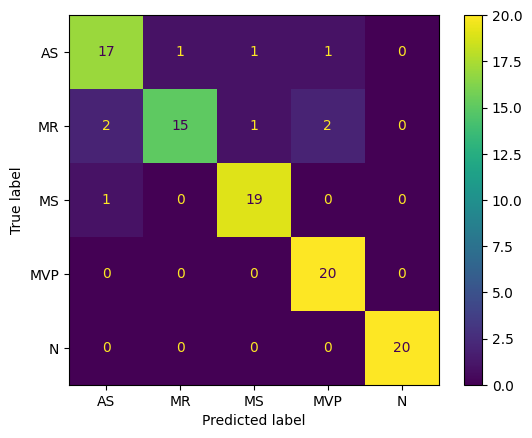

Accuracy : [0.94 0.94 0.97 0.97 1.  ] mean:  0.9639999999999999
Precision : [0.85       0.9375     0.9047619  0.86956522 1.        ] mean:  0.9123654244306418
Sensitivity : [0.85 0.75 0.95 1.   1.  ] mean:  0.9099999999999999
Specificity : [0.9625 0.9875 0.975  0.9625 1.    ] mean:  0.9775
f1_score: [0.85       0.83333333 0.92682927 0.93023256 1.        ] mean:  0.9080790319531102



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb8L5.csv_5.h5
4/4 [==============================] - 1s 8ms/step


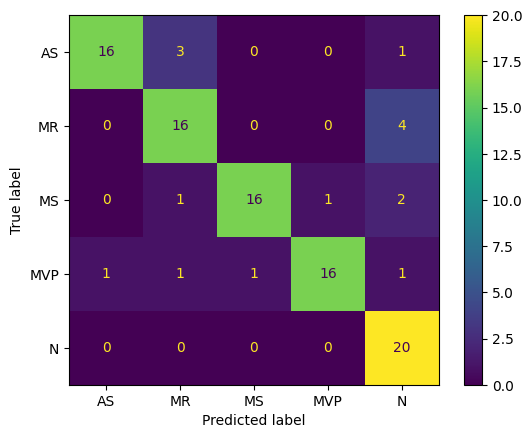

Accuracy : [0.95 0.91 0.95 0.95 0.92] mean:  0.9359999999999999
Precision : [0.94117647 0.76190476 0.94117647 0.94117647 0.71428571] mean:  0.8599439775910364
Sensitivity : [0.8 0.8 0.8 0.8 1. ] mean:  0.8400000000000001
Specificity : [0.9875 0.9375 0.9875 0.9875 0.9   ] mean:  0.9600000000000002
f1_score: [0.86486486 0.7804878  0.86486486 0.86486486 0.83333333] mean:  0.8416831465611953



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb8L6.csv_2.h5
4/4 [==============================] - 0s 8ms/step


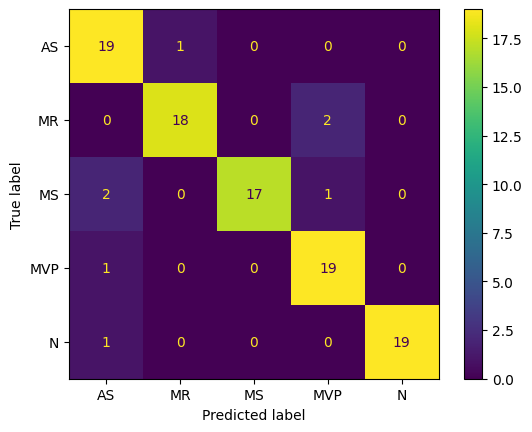

Accuracy : [0.95 0.97 0.97 0.96 0.99] mean:  0.968
Precision : [0.82608696 0.94736842 1.         0.86363636 1.        ] mean:  0.9274183482421469
Sensitivity : [0.95 0.9  0.85 0.95 0.95] mean:  0.9200000000000002
Specificity : [0.95   0.9875 1.     0.9625 1.    ] mean:  0.9800000000000001
f1_score: [0.88372093 0.92307692 0.91891892 0.9047619  0.97435897] mean:  0.9209675302698559



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb8L7.csv_5.h5
4/4 [==============================] - 0s 8ms/step


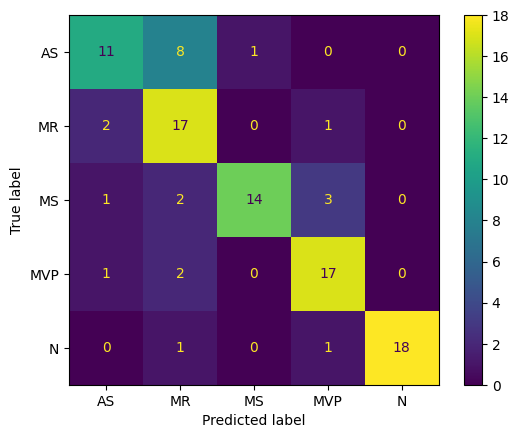

Accuracy : [0.87 0.84 0.93 0.92 0.98] mean:  0.908
Precision : [0.73333333 0.56666667 0.93333333 0.77272727 1.        ] mean:  0.8012121212121212
Sensitivity : [0.55 0.85 0.7  0.85 0.9 ] mean:  0.7699999999999999
Specificity : [0.95   0.8375 0.9875 0.9375 1.    ] mean:  0.9425000000000001
f1_score: [0.62857143 0.68       0.8        0.80952381 0.94736842] mean:  0.7730927318295739



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb8L8.csv_1.h5
4/4 [==============================] - 0s 8ms/step


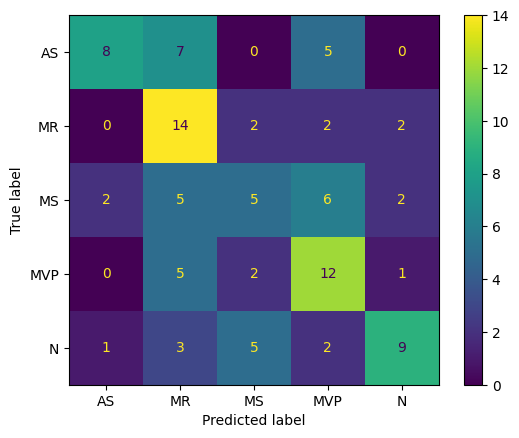

Accuracy : [0.85 0.74 0.76 0.77 0.84] mean:  0.7919999999999999
Precision : [0.72727273 0.41176471 0.35714286 0.44444444 0.64285714] mean:  0.516696375519905
Sensitivity : [0.4  0.7  0.25 0.6  0.45] mean:  0.4800000000000001
Specificity : [0.9625 0.75   0.8875 0.8125 0.9375] mean:  0.8699999999999999
f1_score: [0.51612903 0.51851852 0.29411765 0.5106383  0.52941176] mean:  0.4737630520827259



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb8L9.csv_5.h5
4/4 [==============================] - 1s 9ms/step


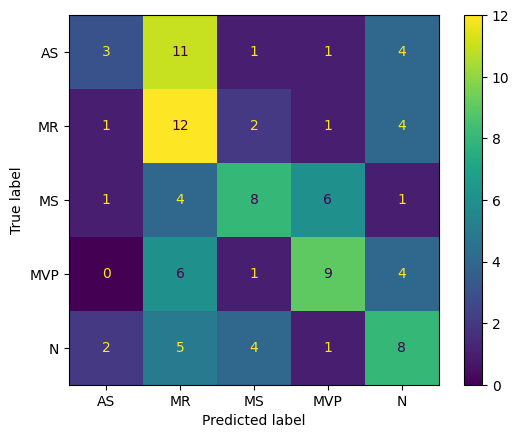

Accuracy : [0.79 0.66 0.8  0.8  0.75] mean:  0.76
Precision : [0.42857143 0.31578947 0.5        0.5        0.38095238] mean:  0.425062656641604
Sensitivity : [0.15 0.6  0.4  0.45 0.4 ] mean:  0.4
Specificity : [0.95   0.675  0.9    0.8875 0.8375] mean:  0.85
f1_score: [0.22222222 0.4137931  0.44444444 0.47368421 0.3902439 ] mean:  0.3888775766160565



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb8L10.csv_5.h5
4/4 [==============================] - 0s 10ms/step


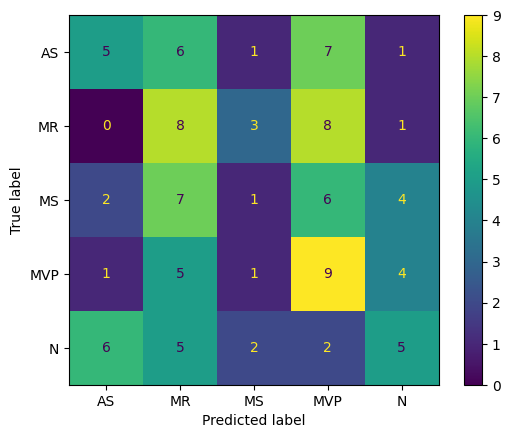

Accuracy : [0.76 0.65 0.74 0.66 0.75] mean:  0.7120000000000001
Precision : [0.35714286 0.25806452 0.125      0.28125    0.33333333] mean:  0.27095814132104457
Sensitivity : [0.25 0.4  0.05 0.45 0.25] mean:  0.28
Specificity : [0.8875 0.7125 0.9125 0.7125 0.875 ] mean:  0.82
f1_score: [0.29411765 0.31372549 0.07142857 0.34615385 0.28571429] mean:  0.26222796811032106



Accuracy All : [0.82, 0.784, 0.916, 0.9639999999999999, 0.9359999999999999, 0.968, 0.908, 0.7919999999999999, 0.76, 0.7120000000000001]
Precision All : [0.5548617533137656, 0.4688651218062983, 0.7977591036414566, 0.9123654244306418, 0.8599439775910364, 0.9274183482421469, 0.8012121212121212, 0.516696375519905, 0.425062656641604, 0.27095814132104457]
Sensitivity All : [0.55, 0.45999999999999996, 0.79, 0.9099999999999999, 0.8400000000000001, 0.9200000000000002, 0.7699999999999999, 0.4800000000000001, 0.4, 0.28]
Specificity All : [0.8875, 0.8649999999999999, 0.9475, 0.9775, 0.9600000000000002, 0.9800000000000001, 0.9425000

In [14]:
testingVHD(a8, 8)

Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb9L1.csv_3.h5
4/4 [==============================] - 1s 9ms/step


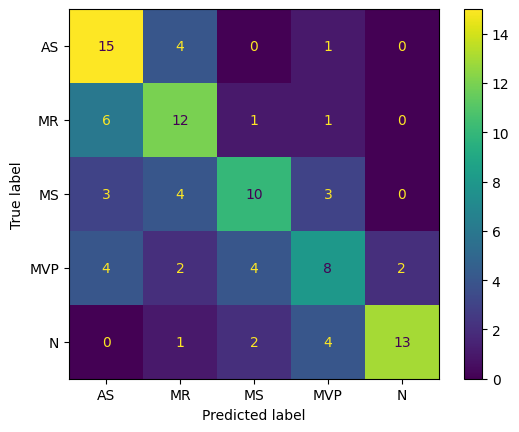

Accuracy : [0.82 0.81 0.83 0.79 0.91] mean:  0.8320000000000001
Precision : [0.53571429 0.52173913 0.58823529 0.47058824 0.86666667] mean:  0.5965887224455
Sensitivity : [0.75 0.6  0.5  0.4  0.65] mean:  0.58
Specificity : [0.8375 0.8625 0.9125 0.8875 0.975 ] mean:  0.8949999999999999
f1_score: [0.625      0.55813953 0.54054054 0.43243243 0.74285714] mean:  0.5797939301427674



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb9L2.csv_5.h5
4/4 [==============================] - 0s 9ms/step


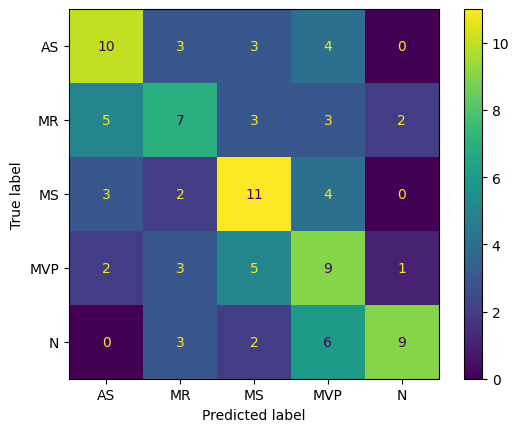

Accuracy : [0.8  0.76 0.78 0.72 0.86] mean:  0.7839999999999999
Precision : [0.5        0.38888889 0.45833333 0.34615385 0.75      ] mean:  0.4886752136752136
Sensitivity : [0.5  0.35 0.55 0.45 0.45] mean:  0.45999999999999996
Specificity : [0.875  0.8625 0.8375 0.7875 0.9625] mean:  0.865
f1_score: [0.5        0.36842105 0.5        0.39130435 0.5625    ] mean:  0.4644450800915331



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb9L3.csv_2.h5
4/4 [==============================] - 1s 12ms/step


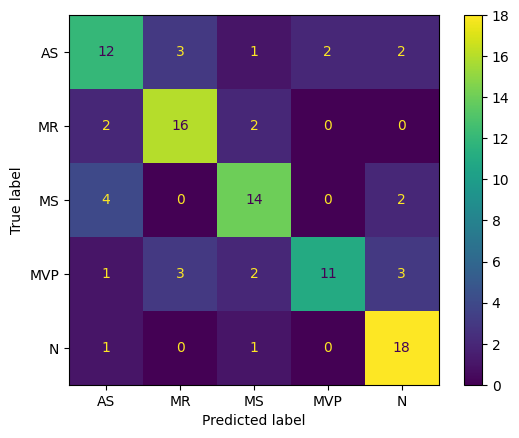

Accuracy : [0.84 0.9  0.88 0.89 0.91] mean:  0.884
Precision : [0.6        0.72727273 0.7        0.84615385 0.72      ] mean:  0.7186853146853147
Sensitivity : [0.6  0.8  0.7  0.55 0.9 ] mean:  0.7099999999999999
Specificity : [0.9    0.925  0.925  0.975  0.9125] mean:  0.9275
f1_score: [0.6        0.76190476 0.7        0.66666667 0.8       ] mean:  0.7057142857142857



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb9L4.csv_2.h5
4/4 [==============================] - 1s 9ms/step


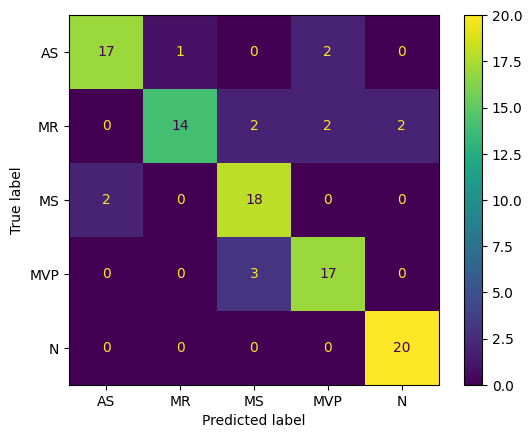

Accuracy : [0.95 0.93 0.93 0.93 0.98] mean:  0.9440000000000002
Precision : [0.89473684 0.93333333 0.7826087  0.80952381 0.90909091] mean:  0.8658587179410977
Sensitivity : [0.85 0.7  0.9  0.85 1.  ] mean:  0.86
Specificity : [0.975  0.9875 0.9375 0.95   0.975 ] mean:  0.9649999999999999
f1_score: [0.87179487 0.8        0.8372093  0.82926829 0.95238095] mean:  0.8581306838368665



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb9L5.csv_2.h5
4/4 [==============================] - 1s 9ms/step


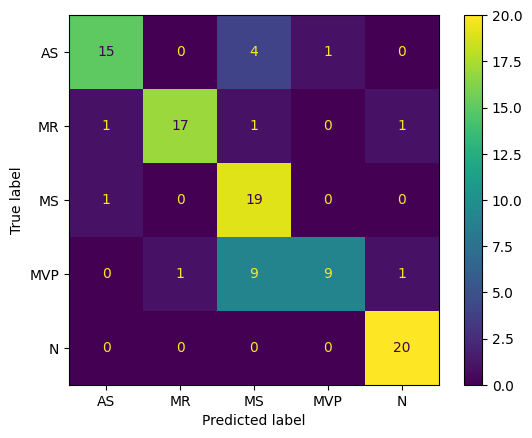

Accuracy : [0.93 0.96 0.85 0.88 0.98] mean:  0.9199999999999999
Precision : [0.88235294 0.94444444 0.57575758 0.9        0.90909091] mean:  0.8423291740938799
Sensitivity : [0.75 0.85 0.95 0.45 1.  ] mean:  0.8
Specificity : [0.975  0.9875 0.825  0.9875 0.975 ] mean:  0.9499999999999998
f1_score: [0.81081081 0.89473684 0.71698113 0.6        0.95238095] mean:  0.7949819474744995



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb9L6.csv_2.h5
4/4 [==============================] - 0s 9ms/step


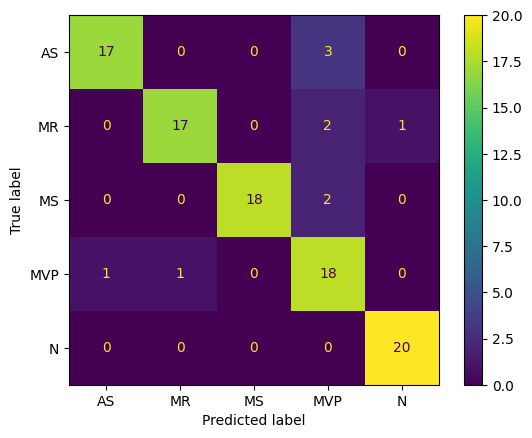

Accuracy : [0.96 0.96 0.98 0.91 0.99] mean:  0.96
Precision : [0.94444444 0.94444444 1.         0.72       0.95238095] mean:  0.9122539682539683
Sensitivity : [0.85 0.85 0.9  0.9  1.  ] mean:  0.9
Specificity : [0.9875 0.9875 1.     0.9125 0.9875] mean:  0.975
f1_score: [0.89473684 0.89473684 0.94736842 0.8        0.97560976] mean:  0.9024903722721437



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb9L7.csv_5.h5
4/4 [==============================] - 1s 9ms/step


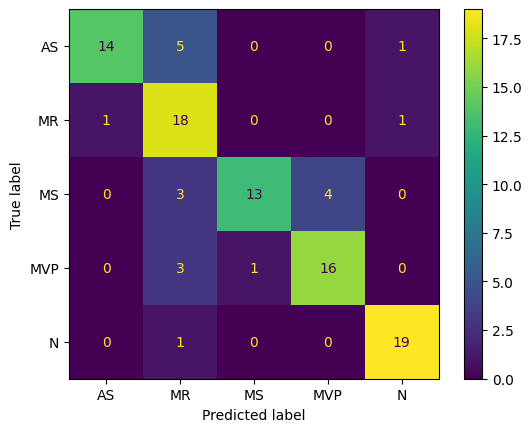

Accuracy : [0.93 0.86 0.92 0.92 0.97] mean:  0.9199999999999999
Precision : [0.93333333 0.6        0.92857143 0.8        0.9047619 ] mean:  0.8333333333333334
Sensitivity : [0.7  0.9  0.65 0.8  0.95] mean:  0.8
Specificity : [0.9875 0.85   0.9875 0.95   0.975 ] mean:  0.95
f1_score: [0.8        0.72       0.76470588 0.8        0.92682927] mean:  0.8023070301291249



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb9L8.csv_1.h5
4/4 [==============================] - 0s 9ms/step


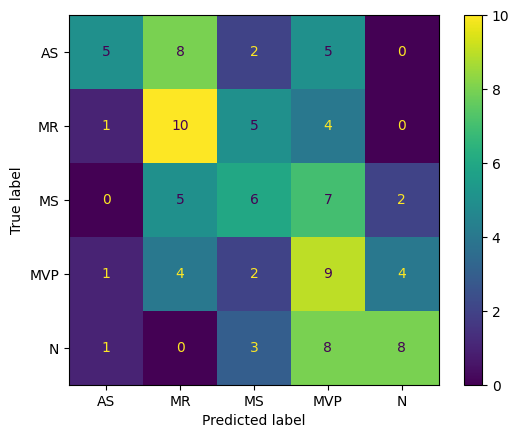

Accuracy : [0.82 0.73 0.74 0.65 0.82] mean:  0.752
Precision : [0.625      0.37037037 0.33333333 0.27272727 0.57142857] mean:  0.43457190957190955
Sensitivity : [0.25 0.5  0.3  0.45 0.4 ] mean:  0.38
Specificity : [0.9625 0.7875 0.85   0.7    0.925 ] mean:  0.845
f1_score: [0.35714286 0.42553191 0.31578947 0.33962264 0.47058824] mean:  0.38173502450484725



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb9L9.csv_2.h5
4/4 [==============================] - 1s 9ms/step


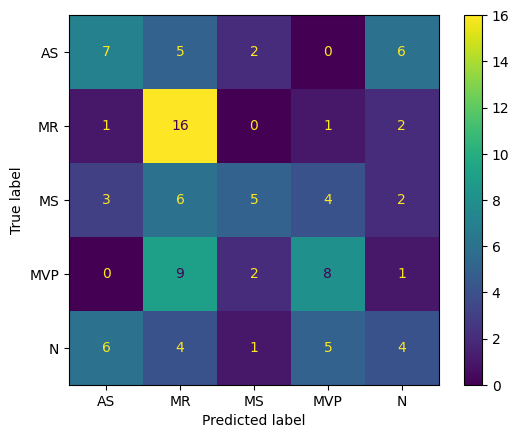

Accuracy : [0.77 0.72 0.8  0.78 0.73] mean:  0.76
Precision : [0.41176471 0.4        0.5        0.44444444 0.26666667] mean:  0.4045751633986928
Sensitivity : [0.35 0.8  0.25 0.4  0.2 ] mean:  0.39999999999999997
Specificity : [0.875  0.7    0.9375 0.875  0.8625] mean:  0.85
f1_score: [0.37837838 0.53333333 0.33333333 0.42105263 0.22857143] mean:  0.3789338210390842



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb9L10.csv_5.h5
4/4 [==============================] - 1s 10ms/step


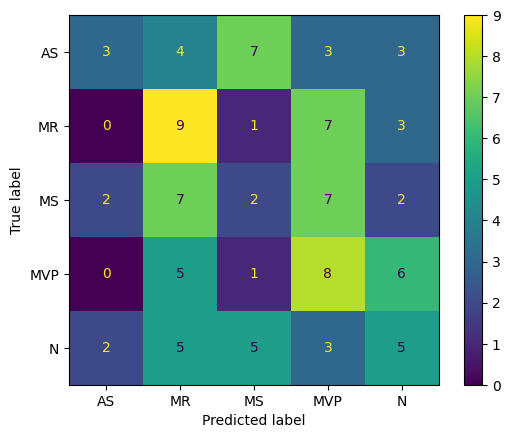

Accuracy : [0.79 0.68 0.68 0.68 0.71] mean:  0.7080000000000001
Precision : [0.42857143 0.3        0.125      0.28571429 0.26315789] mean:  0.28048872180451123
Sensitivity : [0.15 0.45 0.1  0.4  0.25] mean:  0.27
Specificity : [0.95   0.7375 0.825  0.75   0.825 ] mean:  0.8175000000000001
f1_score: [0.22222222 0.36       0.11111111 0.33333333 0.25641026] mean:  0.2566153846153846



Accuracy All : [0.8320000000000001, 0.7839999999999999, 0.884, 0.9440000000000002, 0.9199999999999999, 0.96, 0.9199999999999999, 0.752, 0.76, 0.7080000000000001]
Precision All : [0.5965887224455, 0.4886752136752136, 0.7186853146853147, 0.8658587179410977, 0.8423291740938799, 0.9122539682539683, 0.8333333333333334, 0.43457190957190955, 0.4045751633986928, 0.28048872180451123]
Sensitivity All : [0.58, 0.45999999999999996, 0.7099999999999999, 0.86, 0.8, 0.9, 0.8, 0.38, 0.39999999999999997, 0.27]
Specificity All : [0.8949999999999999, 0.865, 0.9275, 0.9649999999999999, 0.9499999999999998, 0.975, 0.95, 0.845, 0.

In [15]:
testingVHD(a9, 9)

Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb10L1.csv_3.h5


4/4 [==============================] - 0s 10ms/step


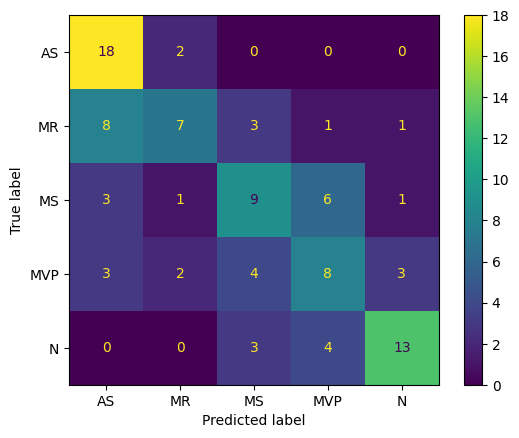

Accuracy : [0.84 0.82 0.79 0.77 0.88] mean:  0.8200000000000001
Precision : [0.5625     0.58333333 0.47368421 0.42105263 0.72222222] mean:  0.5525584795321639
Sensitivity : [0.9  0.35 0.45 0.4  0.65] mean:  0.55
Specificity : [0.825  0.9375 0.875  0.8625 0.9375] mean:  0.8875
f1_score: [0.69230769 0.4375     0.46153846 0.41025641 0.68421053] mean:  0.5371626180836706



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb10L2.csv_3.h5
4/4 [==============================] - 1s 9ms/step


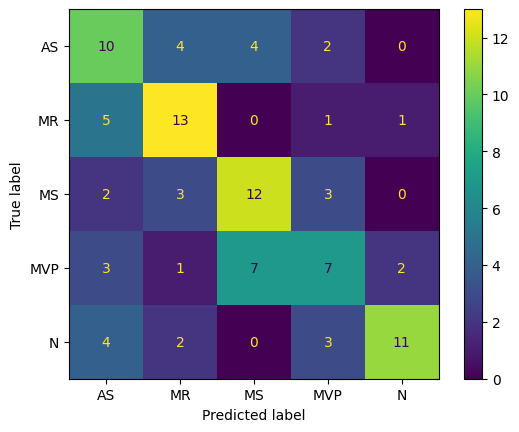

Accuracy : [0.76 0.83 0.81 0.78 0.88] mean:  0.8119999999999999
Precision : [0.41666667 0.56521739 0.52173913 0.4375     0.78571429] mean:  0.5453674948240165
Sensitivity : [0.5  0.65 0.6  0.35 0.55] mean:  0.53
Specificity : [0.825  0.875  0.8625 0.8875 0.9625] mean:  0.8825000000000001
f1_score: [0.45454545 0.60465116 0.55813953 0.38888889 0.64705882] mean:  0.5306567729276347



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb10L3.csv_2.h5
4/4 [==============================] - 1s 9ms/step


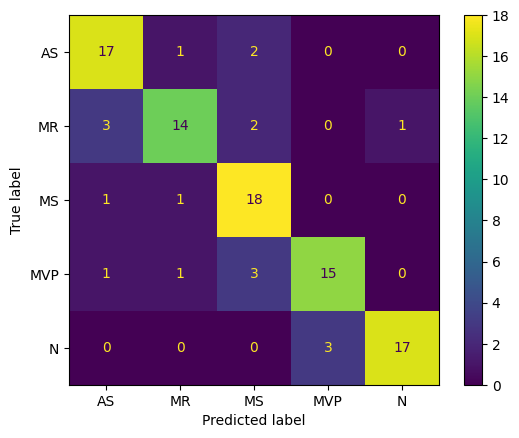

Accuracy : [0.92 0.91 0.91 0.92 0.96] mean:  0.924
Precision : [0.77272727 0.82352941 0.72       0.83333333 0.94444444] mean:  0.8188068924539513
Sensitivity : [0.85 0.7  0.9  0.75 0.85] mean:  0.8099999999999999
Specificity : [0.9375 0.9625 0.9125 0.9625 0.9875] mean:  0.9525
f1_score: [0.80952381 0.75675676 0.8        0.78947368 0.89473684] mean:  0.8100982185192711



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb10L4.csv_2.h5
4/4 [==============================] - 1s 9ms/step


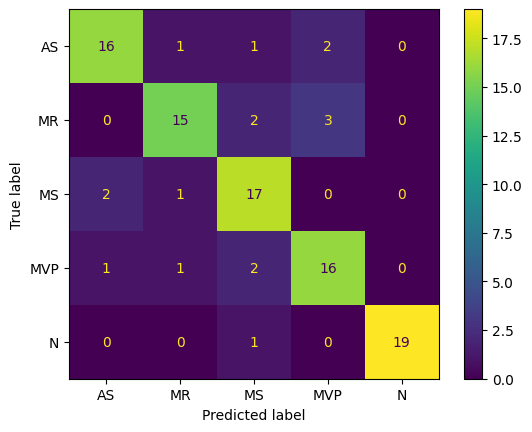

Accuracy : [0.93 0.92 0.91 0.91 0.99] mean:  0.932
Precision : [0.84210526 0.83333333 0.73913043 0.76190476 1.        ] mean:  0.8352947586357198
Sensitivity : [0.8  0.75 0.85 0.8  0.95] mean:  0.8300000000000001
Specificity : [0.9625 0.9625 0.925  0.9375 1.    ] mean:  0.9574999999999999
f1_score: [0.82051282 0.78947368 0.79069767 0.7804878  0.97435897] mean:  0.831106191675795



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb10L5.csv_2.h5
4/4 [==============================] - 0s 9ms/step


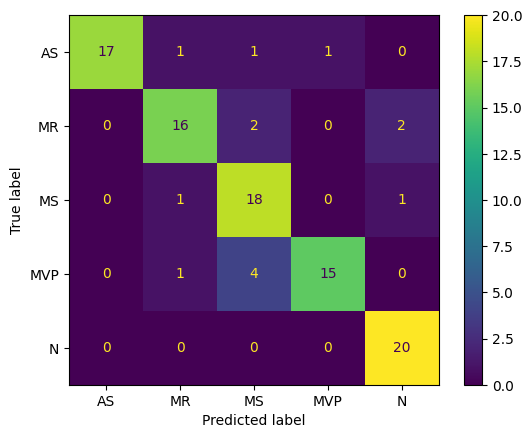

Accuracy : [0.97 0.93 0.91 0.94 0.97] mean:  0.944
Precision : [1.         0.84210526 0.72       0.9375     0.86956522] mean:  0.8738340961098399
Sensitivity : [0.85 0.8  0.9  0.75 1.  ] mean:  0.86
Specificity : [1.     0.9625 0.9125 0.9875 0.9625] mean:  0.9650000000000001
f1_score: [0.91891892 0.82051282 0.8        0.83333333 0.93023256] mean:  0.8605995261809216



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb10L6.csv_2.h5
4/4 [==============================] - 1s 9ms/step


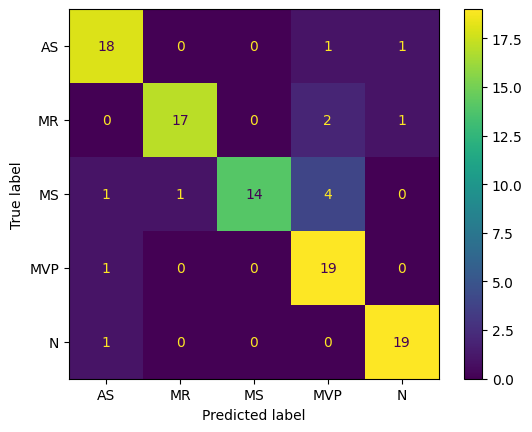

Accuracy : [0.95 0.96 0.94 0.92 0.97] mean:  0.9479999999999998
Precision : [0.85714286 0.94444444 1.         0.73076923 0.9047619 ] mean:  0.8874236874236875
Sensitivity : [0.9  0.85 0.7  0.95 0.95] mean:  0.8700000000000001
Specificity : [0.9625 0.9875 1.     0.9125 0.975 ] mean:  0.9675
f1_score: [0.87804878 0.89473684 0.82352941 0.82608696 0.92682927] mean:  0.8698462518344392



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb10L7.csv_2.h5
4/4 [==============================] - 0s 9ms/step


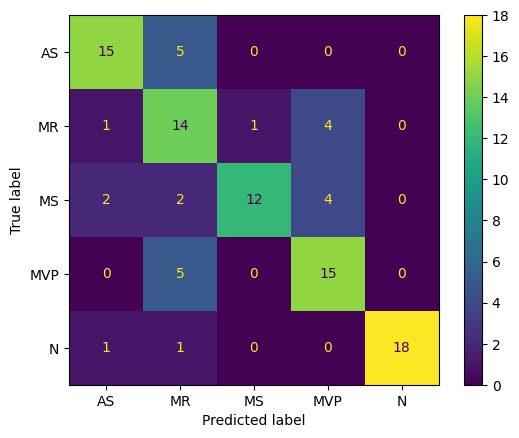

Accuracy : [0.91 0.81 0.91 0.87 0.98] mean:  0.8960000000000001
Precision : [0.78947368 0.51851852 0.92307692 0.65217391 1.        ] mean:  0.7766486077698893
Sensitivity : [0.75 0.7  0.6  0.75 0.9 ] mean:  0.74
Specificity : [0.95   0.8375 0.9875 0.9    1.    ] mean:  0.9350000000000002
f1_score: [0.76923077 0.59574468 0.72727273 0.69767442 0.94736842] mean:  0.7474582034023687



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb10L8.csv_5.h5
4/4 [==============================] - 0s 9ms/step


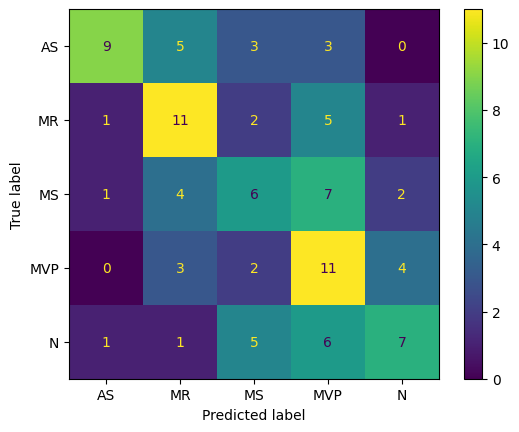

Accuracy : [0.86 0.78 0.74 0.7  0.8 ] mean:  0.776
Precision : [0.75       0.45833333 0.33333333 0.34375    0.5       ] mean:  0.4770833333333333
Sensitivity : [0.45 0.55 0.3  0.55 0.35] mean:  0.44000000000000006
Specificity : [0.9625 0.8375 0.85   0.7375 0.9125] mean:  0.86
f1_score: [0.5625     0.5        0.31578947 0.42307692 0.41176471] mean:  0.4426262205286974



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb10L9.csv_4.h5
4/4 [==============================] - 1s 9ms/step


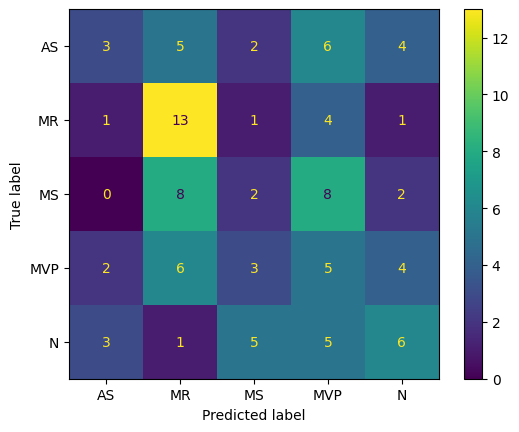

Accuracy : [0.77 0.73 0.71 0.62 0.75] mean:  0.716
Precision : [0.33333333 0.39393939 0.15384615 0.17857143 0.35294118] mean:  0.2825262972321796
Sensitivity : [0.15 0.65 0.1  0.25 0.3 ] mean:  0.29
Specificity : [0.925  0.75   0.8625 0.7125 0.8625] mean:  0.8225
f1_score: [0.20689655 0.49056604 0.12121212 0.20833333 0.32432432] mean:  0.27026647366595313



Processing ../modelh5/LSTM_FT/best_model/LSTM_FT_KFold_data_MfccDwtChromaCqtdb10L10.csv_5.h5
4/4 [==============================] - 1s 9ms/step


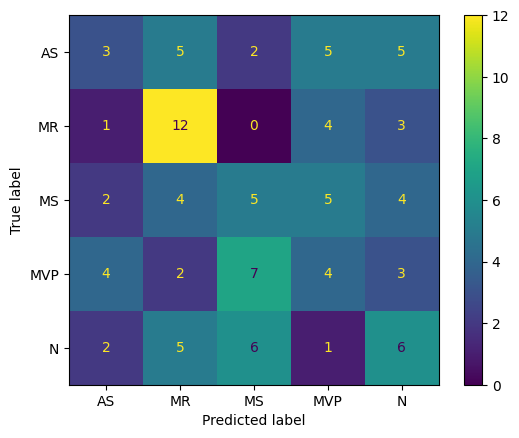

Accuracy : [0.74 0.76 0.7  0.69 0.71] mean:  0.72
Precision : [0.25       0.42857143 0.25       0.21052632 0.28571429] mean:  0.2849624060150376
Sensitivity : [0.15 0.6  0.25 0.2  0.3 ] mean:  0.3
Specificity : [0.8875 0.8    0.8125 0.8125 0.8125] mean:  0.825
f1_score: [0.1875     0.5        0.25       0.20512821 0.29268293] mean:  0.2870622263914947



Accuracy All : [0.8200000000000001, 0.8119999999999999, 0.924, 0.932, 0.944, 0.9479999999999998, 0.8960000000000001, 0.776, 0.716, 0.72]
Precision All : [0.5525584795321639, 0.5453674948240165, 0.8188068924539513, 0.8352947586357198, 0.8738340961098399, 0.8874236874236875, 0.7766486077698893, 0.4770833333333333, 0.2825262972321796, 0.2849624060150376]
Sensitivity All : [0.55, 0.53, 0.8099999999999999, 0.8300000000000001, 0.86, 0.8700000000000001, 0.74, 0.44000000000000006, 0.29, 0.3]
Specificity All : [0.8875, 0.8825000000000001, 0.9525, 0.9574999999999999, 0.9650000000000001, 0.9675, 0.9350000000000002, 0.86, 0.8225, 0.825]
f1_score A

In [16]:
testingVHD(a10, 10)